# Analysis of COVID-19 County Data from The New York Times

*Author: Mark Bauer*  
*Date: April 11, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.0.2
matplotlib.pyplot 3.0.2
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

covid_19_counties_data = pd.read_csv(url)

In [4]:
covid_19_counties_data.head(10)

date       county       state     fips  cases  deaths
0  2020-01-21    Snohomish  Washington  53061.0      1       0
1  2020-01-22    Snohomish  Washington  53061.0      1       0
2  2020-01-23    Snohomish  Washington  53061.0      1       0
3  2020-01-24         Cook    Illinois  17031.0      1       0
4  2020-01-24    Snohomish  Washington  53061.0      1       0
5  2020-01-25       Orange  California   6059.0      1       0
6  2020-01-25         Cook    Illinois  17031.0      1       0
7  2020-01-25    Snohomish  Washington  53061.0      1       0
8  2020-01-26     Maricopa     Arizona   4013.0      1       0
9  2020-01-26  Los Angeles  California   6037.0      1       0

In [5]:
table = covid_19_counties_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="county", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | county        | state      | cases   | deaths   |
|---:|:-----------|:--------------|:-----------|:--------|:---------|
|  0 | 2020-04-22 | New York City | New York   | 142,442 | 10,614   |
|  1 | 2020-04-22 | Nassau        | New York   | 31,555  | 1,764    |
|  2 | 2020-04-22 | Suffolk       | New York   | 28,854  | 959      |
|  3 | 2020-04-22 | Westchester   | New York   | 25,275  | 932      |
|  4 | 2020-04-22 | Cook          | Illinois   | 24,546  | 1,072    |
|  5 | 2020-04-22 | Los Angeles   | California | 16,435  | 729      |
|  6 | 2020-04-22 | Wayne         | Michigan   | 14,561  | 1,319    |
|  7 | 2020-04-22 | Bergen        | New Jersey | 13,686  | 876      |
|  8 | 2020-04-22 | Hudson        | New Jersey | 12,039  | 568      |
|  9 | 2020-04-22 | Essex         | New Jersey | 11,387  | 888      |


In [6]:
covid_19_counties_data.shape

(81339, 6)

In [7]:
print('New York Times COVID-19 data as of', covid_19_counties_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-04-22


In [8]:
current_date = covid_19_counties_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-04-22


In [10]:
covid_19_counties_data.date = pd.to_datetime(covid_19_counties_data.date, infer_datetime_format=True)

In [11]:
covid_19_counties_data.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths             int64
dtype: object

In [12]:
print(covid_19_counties_data['county'])

0         Snohomish
1         Snohomish
2         Snohomish
3              Cook
4         Snohomish
            ...    
81334      Sublette
81335    Sweetwater
81336         Teton
81337         Uinta
81338      Washakie
Name: county, Length: 81339, dtype: object


In [13]:
covid_19_counties_data['county_name'] = (covid_19_counties_data['county'] + ", " + covid_19_counties_data['state'])

In [14]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
81334 2020-04-22    Sublette     Wyoming  56035.0      1       0   
81335 2020-04-22  Sweetwater     Wyoming  56037.0     10       0   
81336 2020-04-22       Teton     Wyoming  56039.0     63       0   
81337 2020-04-22       Uinta     Wyoming  56041.0      6       0   
81338 2020-04-22    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
81334      Sublette, Wyoming  
81335    Sweetwater, Wyoming  
81336         Teton, Wyoming  
81337         Uinta, Wyoming  
81338      Washakie, Wyoming  

[81339 rows x 7 columns]

In [15]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

date   county           state  fips  cases  deaths  \
418   2020-03-01  Unknown    Rhode Island   NaN      2       0   
450   2020-03-02  Unknown    Rhode Island   NaN      2       0   
485   2020-03-03  Unknown    Rhode Island   NaN      2       0   
522   2020-03-04  Unknown    Rhode Island   NaN      2       0   
569   2020-03-05  Unknown    Rhode Island   NaN      2       0   
...          ...      ...             ...   ...    ...     ...   
80613 2020-04-22  Unknown     Puerto Rico   NaN    915      46   
80618 2020-04-22  Unknown    Rhode Island   NaN   1000     161   
81019 2020-04-22  Unknown            Utah   NaN      0       2   
81035 2020-04-22  Unknown         Vermont   NaN      3       0   
81039 2020-04-22  Unknown  Virgin Islands   NaN     51       2   

                   county_name  
418      Unknown, Rhode Island  
450      Unknown, Rhode Island  
485      Unknown, Rhode Island  
522      Unknown, Rhode Island  
569      Unknown, Rhode Island  
...                        ...  
80613     Unknown, Puerto Rico  
80618    Unknown, Rhode Island  
81019            Unknown, Utah  
81035         Unknown, Vermont  
81039  Unknown, Virgin Islands  

[929 rows x 7 columns]

In [16]:
print(len(covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']))

929


In [17]:
covid_19_counties_data = covid_19_counties_data.loc[covid_19_counties_data.county != 'Unknown']

In [18]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

Empty DataFrame
Columns: [date, county, state, fips, cases, deaths, county_name]
Index: []

# Begin Analysis

In [19]:
covid_19_counties_data.dtypes

date           datetime64[ns]
county                 object
state                  object
fips                  float64
cases                   int64
deaths                  int64
county_name            object
dtype: object

In [20]:
epi_curve = covid_19_counties_data.sort_values(by='date')

In [21]:
epi_curve = epi_curve.groupby(by='date')['cases'].sum().reset_index()

In [22]:
epi_curve['NewDate'] = epi_curve.date.dt.strftime("%m-%d")

In [23]:
epi_curve

date   cases NewDate
0  2020-01-21       1   01-21
1  2020-01-22       1   01-22
2  2020-01-23       1   01-23
3  2020-01-24       2   01-24
4  2020-01-25       3   01-25
..        ...     ...     ...
88 2020-04-18  721808   04-18
89 2020-04-19  747262   04-19
90 2020-04-20  773989   04-20
91 2020-04-21  799200   04-21
92 2020-04-22  826293   04-22

[93 rows x 3 columns]

In [24]:
epi_curve['daily_cases'] = epi_curve['cases'].diff()

In [25]:
epi_curve.head()

date  cases NewDate  daily_cases
0 2020-01-21      1   01-21          NaN
1 2020-01-22      1   01-22          0.0
2 2020-01-23      1   01-23          0.0
3 2020-01-24      2   01-24          1.0
4 2020-01-25      3   01-25          1.0

In [26]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

0   NaN
Name: daily_cases, dtype: float64

In [27]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()] = epi_curve.cases

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

Series([], Name: daily_cases, dtype: float64)

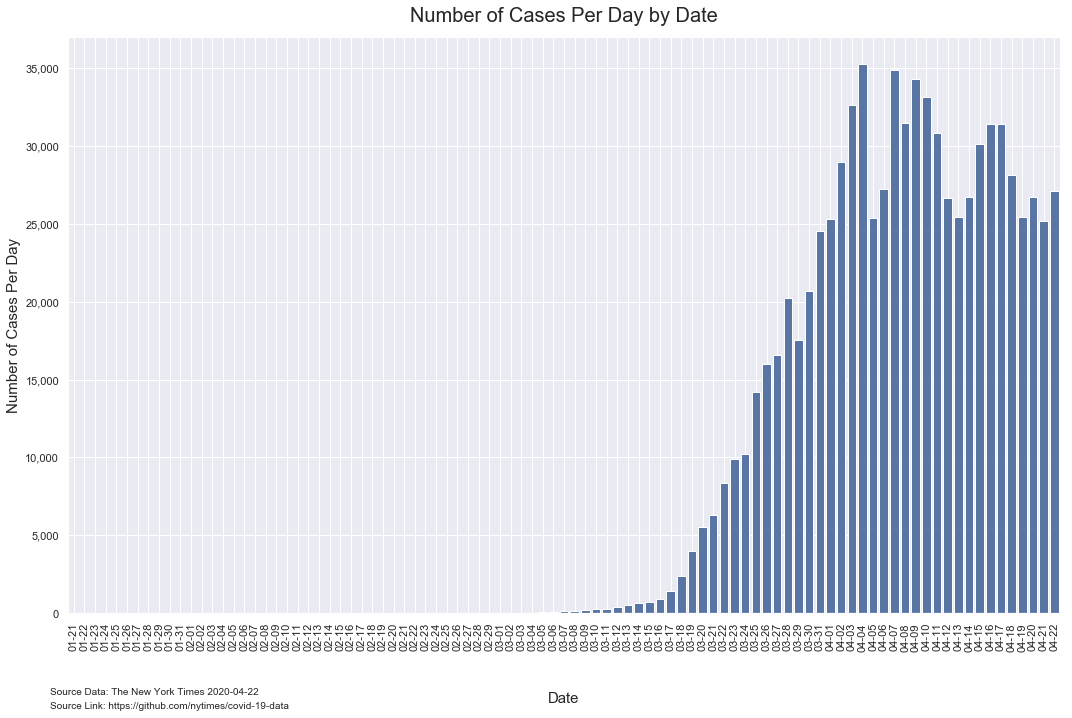

In [29]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

#ax1.legend_.remove()
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

In [30]:
epi_curve['3_day_rolling_average'] = epi_curve.daily_cases.rolling(3).mean()

In [31]:
epi_curve

date   cases NewDate  daily_cases  3_day_rolling_average
0  2020-01-21       1   01-21          1.0                    NaN
1  2020-01-22       1   01-22          0.0                    NaN
2  2020-01-23       1   01-23          0.0               0.333333
3  2020-01-24       2   01-24          1.0               0.333333
4  2020-01-25       3   01-25          1.0               0.666667
..        ...     ...     ...          ...                    ...
88 2020-04-18  721808   04-18      28130.0           30315.333333
89 2020-04-19  747262   04-19      25454.0           28322.666667
90 2020-04-20  773989   04-20      26727.0           26770.333333
91 2020-04-21  799200   04-21      25211.0           25797.333333
92 2020-04-22  826293   04-22      27093.0           26343.666667

[93 rows x 5 columns]

In [32]:
epi_curve['3_day_rolling_average'].fillna(0, inplace=True)

In [33]:
epi_curve.head()

date  cases NewDate  daily_cases  3_day_rolling_average
0 2020-01-21      1   01-21          1.0               0.000000
1 2020-01-22      1   01-22          0.0               0.000000
2 2020-01-23      1   01-23          0.0               0.333333
3 2020-01-24      2   01-24          1.0               0.333333
4 2020-01-25      3   01-25          1.0               0.666667

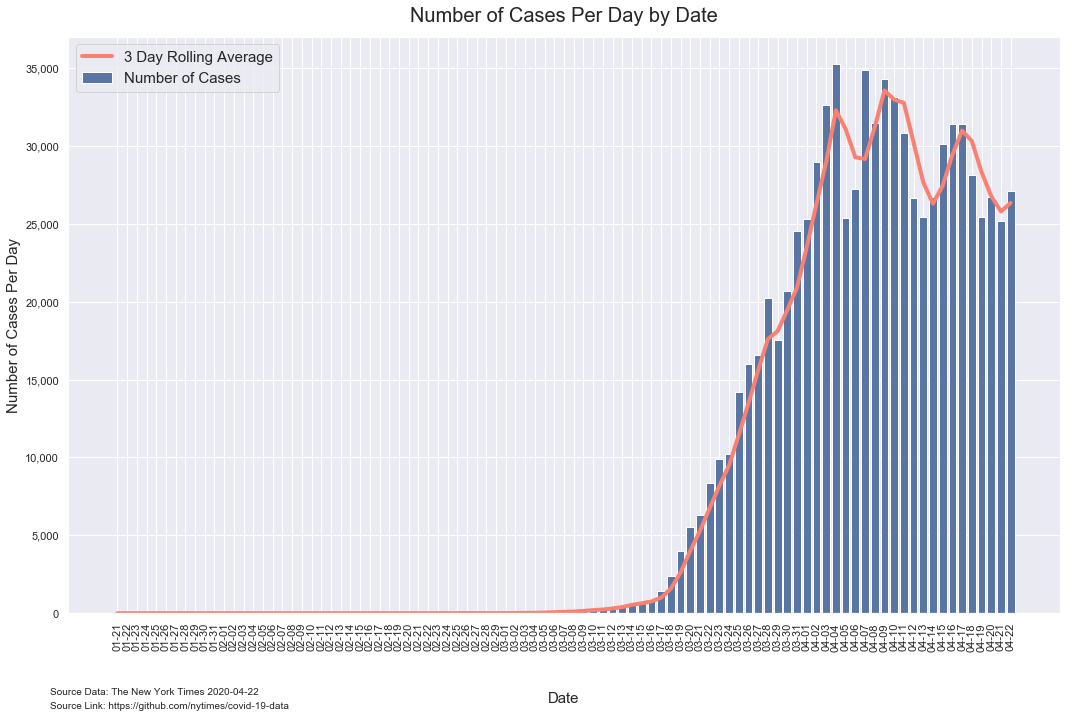

In [34]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve,
            label = 'Number of Cases')

sns.lineplot(x="NewDate", 
            y="3_day_rolling_average",
            color="salmon",
            data=epi_curve, 
            linewidth=4,
            label = '3 Day Rolling Average')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('D'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

leg = ax1.legend(loc='upper left', fontsize=15)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/epi_curve')

In [35]:
drop_duplicates = covid_19_counties_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="county_name", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.county_name)
top_10  = covid_19_counties_data.loc[covid_19_counties_data['county_name'].isin(top10_list)]

In [36]:
top_10

date         county       state     fips   cases  deaths  \
3     2020-01-24           Cook    Illinois  17031.0       1       0   
6     2020-01-25           Cook    Illinois  17031.0       1       0   
9     2020-01-26    Los Angeles  California   6037.0       1       0   
11    2020-01-26           Cook    Illinois  17031.0       1       0   
14    2020-01-27    Los Angeles  California   6037.0       1       0   
...          ...            ...         ...      ...     ...     ...   
80132 2020-04-22         Hudson  New Jersey  34017.0   12039     568   
80201 2020-04-22         Nassau    New York  36059.0   31555    1764   
80202 2020-04-22  New York City    New York      NaN  142442   10614   
80221 2020-04-22        Suffolk    New York  36103.0   28854     959   
80229 2020-04-22    Westchester    New York  36119.0   25275     932   

                   county_name  
3               Cook, Illinois  
6               Cook, Illinois  
9      Los Angeles, California  
11              Cook, Illinois  
14     Los Angeles, California  
...                        ...  
80132       Hudson, New Jersey  
80201         Nassau, New York  
80202  New York City, New York  
80221        Suffolk, New York  
80229    Westchester, New York  

[557 rows x 7 columns]

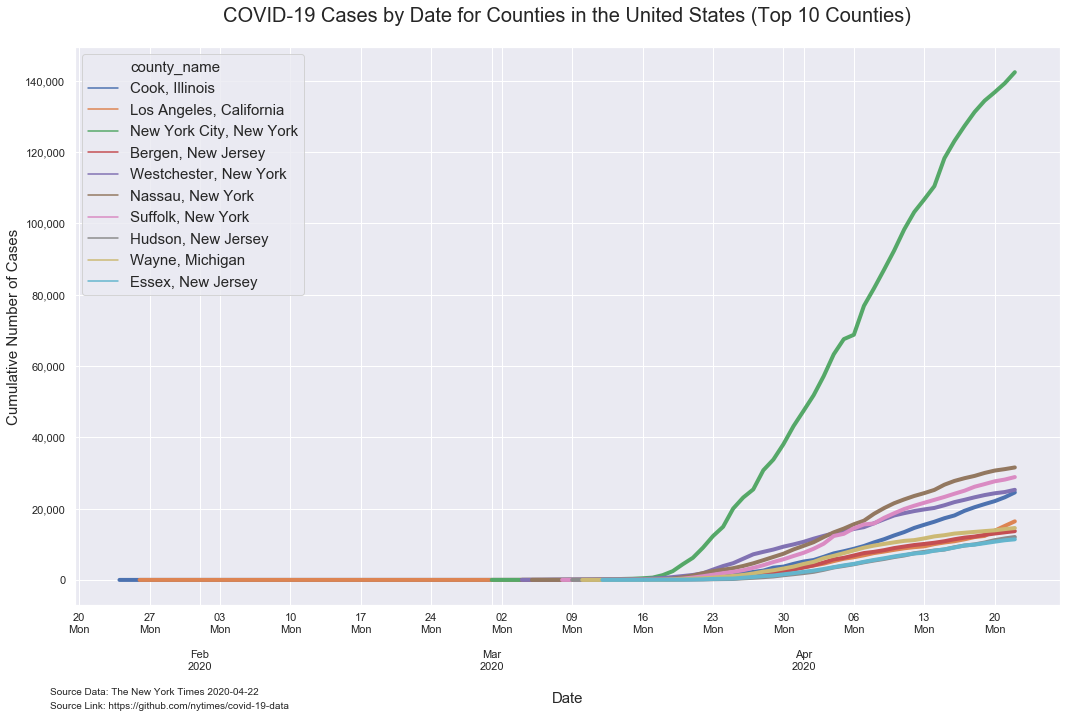

In [37]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10')

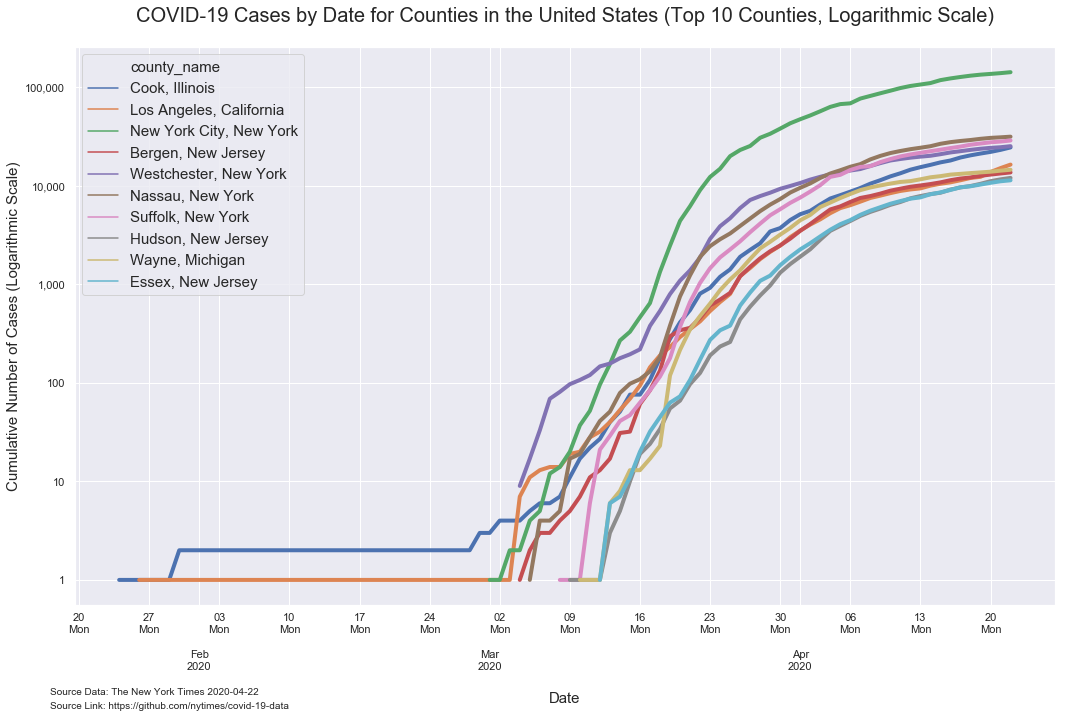

In [38]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10-log')

# Date to 10 Cases

In [39]:
county_ten_cases = top_10.loc[top_10.cases >= 10]

In [40]:
county_ten_cases = county_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="county_name", 
                                                                                      keep = 'first').reset_index(drop=True)

In [41]:
county_ten_cases = county_ten_cases[['date', 'county_name']]
county_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [42]:
county_ten_cases

date_ten_case              county_name
0    2020-03-05  Los Angeles, California
1    2020-03-05    Westchester, New York
2    2020-03-07  New York City, New York
3    2020-03-09           Cook, Illinois
4    2020-03-09         Nassau, New York
5    2020-03-11       Bergen, New Jersey
6    2020-03-12        Suffolk, New York
7    2020-03-15       Hudson, New Jersey
8    2020-03-15        Essex, New Jersey
9    2020-03-15          Wayne, Michigan

In [43]:
county_ten_cases = top_10.merge(county_ten_cases, left_on='county_name', right_on='county_name')

In [44]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
0   2020-01-24   Cook    Illinois  17031.0      1       0     Cook, Illinois   
1   2020-01-25   Cook    Illinois  17031.0      1       0     Cook, Illinois   
2   2020-01-26   Cook    Illinois  17031.0      1       0     Cook, Illinois   
3   2020-01-27   Cook    Illinois  17031.0      1       0     Cook, Illinois   
4   2020-01-28   Cook    Illinois  17031.0      1       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
552 2020-04-18  Essex  New Jersey  34013.0   9901     732  Essex, New Jersey   
553 2020-04-19  Essex  New Jersey  34013.0  10304     740  Essex, New Jersey   
554 2020-04-20  Essex  New Jersey  34013.0  10729     751  Essex, New Jersey   
555 2020-04-21  Essex  New Jersey  34013.0  11128     849  Essex, New Jersey   
556 2020-04-22  Essex  New Jersey  34013.0  11387     888  Essex, New Jersey   

    date_ten_case  
0      2020-03-09  
1      2020-03-09  
2      2020-03-09  
3      2020-03-09  
4      2020-03-09  
..            ...  
552    2020-03-15  
553    2020-03-15  
554    2020-03-15  
555    2020-03-15  
556    2020-03-15  

[557 rows x 8 columns]

In [45]:
county_ten_cases = county_ten_cases.loc[county_ten_cases.cases >= 10]

In [46]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
552 2020-04-18  Essex  New Jersey  34013.0   9901     732  Essex, New Jersey   
553 2020-04-19  Essex  New Jersey  34013.0  10304     740  Essex, New Jersey   
554 2020-04-20  Essex  New Jersey  34013.0  10729     751  Essex, New Jersey   
555 2020-04-21  Essex  New Jersey  34013.0  11128     849  Essex, New Jersey   
556 2020-04-22  Essex  New Jersey  34013.0  11387     888  Essex, New Jersey   

    date_ten_case  
45     2020-03-09  
46     2020-03-09  
47     2020-03-09  
48     2020-03-09  
49     2020-03-09  
..            ...  
552    2020-03-15  
553    2020-03-15  
554    2020-03-15  
555    2020-03-15  
556    2020-03-15  

[437 rows x 8 columns]

In [47]:
county_ten_cases['days_since_ten_case'] = (county_ten_cases['date'] - 
                                      county_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
552 2020-04-18  Essex  New Jersey  34013.0   9901     732  Essex, New Jersey   
553 2020-04-19  Essex  New Jersey  34013.0  10304     740  Essex, New Jersey   
554 2020-04-20  Essex  New Jersey  34013.0  10729     751  Essex, New Jersey   
555 2020-04-21  Essex  New Jersey  34013.0  11128     849  Essex, New Jersey   
556 2020-04-22  Essex  New Jersey  34013.0  11387     888  Essex, New Jersey   

    date_ten_case  days_since_ten_case  
45     2020-03-09                    0  
46     2020-03-09                    1  
47     2020-03-09                    2  
48     2020-03-09                    3  
49     2020-03-09                    4  
..            ...                  ...  
552    2020-03-15                   34  
553    2020-03-15                   35  
554    2020-03-15                   36  
555    2020-03-15                   37  
556    2020-03-15                   38  

[437 rows x 9 columns]

# Daily Number of Cases Since 10th Case

In [49]:
county_ten_cases['daily_cases'] = (county_ten_cases.cases -
                                county_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
county_ten_cases[:50]

date       county       state     fips  cases  deaths  \
45  2020-03-09         Cook    Illinois  17031.0     11       0   
46  2020-03-10         Cook    Illinois  17031.0     17       0   
47  2020-03-11         Cook    Illinois  17031.0     22       0   
48  2020-03-12         Cook    Illinois  17031.0     27       0   
49  2020-03-13         Cook    Illinois  17031.0     40       0   
50  2020-03-14         Cook    Illinois  17031.0     51       0   
51  2020-03-15         Cook    Illinois  17031.0     76       0   
52  2020-03-16         Cook    Illinois  17031.0     76       0   
53  2020-03-17         Cook    Illinois  17031.0    107       1   
54  2020-03-18         Cook    Illinois  17031.0    179       1   
55  2020-03-19         Cook    Illinois  17031.0    279       2   
56  2020-03-20         Cook    Illinois  17031.0    412       3   
57  2020-03-21         Cook    Illinois  17031.0    548       4   
58  2020-03-22         Cook    Illinois  17031.0    805       6   
59  2020-03-23         Cook    Illinois  17031.0    922       9   
60  2020-03-24         Cook    Illinois  17031.0   1194      12   
61  2020-03-25         Cook    Illinois  17031.0   1418      13   
62  2020-03-26         Cook    Illinois  17031.0   1904      18   
63  2020-03-27         Cook    Illinois  17031.0   2239      20   
64  2020-03-28         Cook    Illinois  17031.0   2613      28   
65  2020-03-29         Cook    Illinois  17031.0   3445      40   
66  2020-03-30         Cook    Illinois  17031.0   3727      44   
67  2020-03-31         Cook    Illinois  17031.0   4496      61   
68  2020-04-01         Cook    Illinois  17031.0   5152      95   
69  2020-04-02         Cook    Illinois  17031.0   5575     107   
70  2020-04-03         Cook    Illinois  17031.0   6473     141   
71  2020-04-04         Cook    Illinois  17031.0   7439     167   
72  2020-04-05         Cook    Illinois  17031.0   8043     186   
73  2020-04-06         Cook    Illinois  17031.0   8728     209   
74  2020-04-07         Cook    Illinois  17031.0   9509     249   
75  2020-04-08         Cook    Illinois  17031.0  10520     312   
76  2020-04-09         Cook    Illinois  17031.0  11415     351   
77  2020-04-10         Cook    Illinois  17031.0  12472     398   
78  2020-04-11         Cook    Illinois  17031.0  13417     453   
79  2020-04-12         Cook    Illinois  17031.0  14585     485   
80  2020-04-13         Cook    Illinois  17031.0  15474     543   
81  2020-04-14         Cook    Illinois  17031.0  16323     577   
82  2020-04-15         Cook    Illinois  17031.0  17306     630   
83  2020-04-16         Cook    Illinois  17031.0  18087     722   
84  2020-04-17         Cook    Illinois  17031.0  19391     760   
85  2020-04-18         Cook    Illinois  17031.0  20395     860   
86  2020-04-19         Cook    Illinois  17031.0  21272     877   
87  2020-04-20         Cook    Illinois  17031.0  22101     915   
88  2020-04-21         Cook    Illinois  17031.0  23181    1002   
89  2020-04-22         Cook    Illinois  17031.0  24546    1072   
129 2020-03-05  Los Angeles  California   6037.0     11       0   
130 2020-03-06  Los Angeles  California   6037.0     13       0   
131 2020-03-07  Los Angeles  California   6037.0     14       0   
132 2020-03-08  Los Angeles  California   6037.0     14       0   
133 2020-03-09  Los Angeles  California   6037.0     19       0   

                 county_name date_ten_case  days_since_ten_case  daily_cases  
45            Cook, Illinois    2020-03-09                    0          NaN  
46            Cook, Illinois    2020-03-09                    1          6.0  
47            Cook, Illinois    2020-03-09                    2          5.0  
48            Cook, Illinois    2020-03-09                    3          5.0  
49            Cook, Illinois    2020-03-09                    4         13.0  
50            Cook, Illinois    2020-03-09                    5         11.0  
51            Cook, Illinois    2020-03

In [51]:
county_ten_cases.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'county_name',
       'date_ten_case', 'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [52]:
county_ten_cases = county_ten_cases[['date', 'county', 'county_name', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [53]:
county_ten_cases[250:300]

date   county        county_name  cases  daily_cases  deaths  \
352 2020-03-26   Nassau   Nassau, New York   3914        629.0      19   
353 2020-03-27   Nassau   Nassau, New York   4657        743.0      27   
354 2020-03-28   Nassau   Nassau, New York   5537        880.0      35   
355 2020-03-29   Nassau   Nassau, New York   6445        908.0      39   
356 2020-03-30   Nassau   Nassau, New York   7344        899.0      48   
357 2020-03-31   Nassau   Nassau, New York   8544       1200.0      63   
358 2020-04-01   Nassau   Nassau, New York   9555       1011.0      76   
359 2020-04-02   Nassau   Nassau, New York  10587       1032.0      95   
360 2020-04-03   Nassau   Nassau, New York  12024       1437.0     138   
361 2020-04-04   Nassau   Nassau, New York  13346       1322.0     396   
362 2020-04-05   Nassau   Nassau, New York  14398       1052.0     396   
363 2020-04-06   Nassau   Nassau, New York  15616       1218.0     535   
364 2020-04-07   Nassau   Nassau, New York  16610        994.0     620   
365 2020-04-08   Nassau   Nassau, New York  18548       1938.0     701   
366 2020-04-09   Nassau   Nassau, New York  20140       1592.0     778   
367 2020-04-10   Nassau   Nassau, New York  21512       1372.0     890   
368 2020-04-11   Nassau   Nassau, New York  22584       1072.0     965   
369 2020-04-12   Nassau   Nassau, New York  23553        969.0    1030   
370 2020-04-13   Nassau   Nassau, New York  24358        805.0    1109   
371 2020-04-14   Nassau   Nassau, New York  25250        892.0    1217   
372 2020-04-15   Nassau   Nassau, New York  26715       1465.0    1286   
373 2020-04-16   Nassau   Nassau, New York  27772       1057.0    1356   
374 2020-04-17   Nassau   Nassau, New York  28539        767.0    1356   
375 2020-04-18   Nassau   Nassau, New York  29180        641.0    1356   
376 2020-04-19   Nassau   Nassau, New York  30013        833.0    1577   
377 2020-04-20   Nassau   Nassau, New York  30677        664.0    1638   
378 2020-04-21   Nassau   Nassau, New York  31079        402.0    1717   
379 2020-04-22   Nassau   Nassau, New York  31555        476.0    1764   
384 2020-03-12  Suffolk  Suffolk, New York     21     -31534.0       0   
385 2020-03-13  Suffolk  Suffolk, New York     29          8.0       0   
386 2020-03-14  Suffolk  Suffolk, New York     41         12.0       0   
387 2020-03-15  Suffolk  Suffolk, New York     47          6.0       0   
388 2020-03-16  Suffolk  Suffolk, New York     63         16.0       2   
389 2020-03-17  Suffolk  Suffolk, New York     84         21.0       3   
390 2020-03-18  Suffolk  Suffolk, New York    116         32.0       3   
391 2020-03-19  Suffolk  Suffolk, New York    178         62.0       3   
392 2020-03-20  Suffolk  Suffolk, New York    371        193.0       7   
393 2020-03-21  Suffolk  Suffolk, New York    662        291.0       9   
394 2020-03-22  Suffolk  Suffolk, New York   1034        372.0      12   
395 2020-03-23  Suffolk  Suffolk, New York   1458        424.0      13   
396 2020-03-24  Suffolk  Suffolk, New York   1880        422.0      13   
397 2020-03-25  Suffolk  Suffolk, New York   2260        380.0      20   
398 2020-03-26  Suffolk  Suffolk, New York   2735        475.0      22   
399 2020-03-27  Suffolk  Suffolk, New York   3385        650.0      22   
400 2020-03-28  Suffolk  Suffolk, New York   4138        753.0      37   
401 2020-03-29  Suffolk  Suffolk, New York   5023        885.0      40   
402 2020-03-30  Suffolk  Suffolk, New York   5791        768.0      44   
403 2020-03-31  Suffolk  Suffolk, New York   6713        922.0      53   
404 2020-04-01  Suffolk  Suffolk, New York   7605        892.0      69   
405 2020-04-02  Suffolk  Suffolk, New York   8746       1141.0      84   

    date_ten_case  days_since_ten_case  
352    2020-03-09                   17  
353    2020-03-09                   18  
354    2020-03-09                   19  
355    2020-03-09                   20  
356    2020-03-09             

In [54]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases < 0] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases.isnull()] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
county_ten_cases[:50]

date       county              county_name  cases  daily_cases  \
45  2020-03-09         Cook           Cook, Illinois     11          1.0   
46  2020-03-10         Cook           Cook, Illinois     17          6.0   
47  2020-03-11         Cook           Cook, Illinois     22          5.0   
48  2020-03-12         Cook           Cook, Illinois     27          5.0   
49  2020-03-13         Cook           Cook, Illinois     40         13.0   
50  2020-03-14         Cook           Cook, Illinois     51         11.0   
51  2020-03-15         Cook           Cook, Illinois     76         25.0   
52  2020-03-16         Cook           Cook, Illinois     76          0.0   
53  2020-03-17         Cook           Cook, Illinois    107         31.0   
54  2020-03-18         Cook           Cook, Illinois    179         72.0   
55  2020-03-19         Cook           Cook, Illinois    279        100.0   
56  2020-03-20         Cook           Cook, Illinois    412        133.0   
57  2020-03-21         Cook           Cook, Illinois    548        136.0   
58  2020-03-22         Cook           Cook, Illinois    805        257.0   
59  2020-03-23         Cook           Cook, Illinois    922        117.0   
60  2020-03-24         Cook           Cook, Illinois   1194        272.0   
61  2020-03-25         Cook           Cook, Illinois   1418        224.0   
62  2020-03-26         Cook           Cook, Illinois   1904        486.0   
63  2020-03-27         Cook           Cook, Illinois   2239        335.0   
64  2020-03-28         Cook           Cook, Illinois   2613        374.0   
65  2020-03-29         Cook           Cook, Illinois   3445        832.0   
66  2020-03-30         Cook           Cook, Illinois   3727        282.0   
67  2020-03-31         Cook           Cook, Illinois   4496        769.0   
68  2020-04-01         Cook           Cook, Illinois   5152        656.0   
69  2020-04-02         Cook           Cook, Illinois   5575        423.0   
70  2020-04-03         Cook           Cook, Illinois   6473        898.0   
71  2020-04-04         Cook           Cook, Illinois   7439        966.0   
72  2020-04-05         Cook           Cook, Illinois   8043        604.0   
73  2020-04-06         Cook           Cook, Illinois   8728        685.0   
74  2020-04-07         Cook           Cook, Illinois   9509        781.0   
75  2020-04-08         Cook           Cook, Illinois  10520       1011.0   
76  2020-04-09         Cook           Cook, Illinois  11415        895.0   
77  2020-04-10         Cook           Cook, Illinois  12472       1057.0   
78  2020-04-11         Cook           Cook, Illinois  13417        945.0   
79  2020-04-12         Cook           Cook, Illinois  14585       1168.0   
80  2020-04-13         Cook           Cook, Illinois  15474        889.0   
81  2020-04-14         Cook           Cook, Illinois  16323        849.0   
82  2020-04-15         Cook           Cook, Illinois  17306        983.0   
83  2020-04-16         Cook           Cook, Illinois  18087        781.0   
84  2020-04-17         Cook           Cook, Illinois  19391       1304.0   
85  2020-04-18         Cook           Cook, Illinois  20395       1004.0   
86  2020-04-19         Cook           Cook, Illinois  21272        877.0   
87  2020-04-20         Cook           Cook, Illinois  22101        829.0   
88  2020-04-21         Cook           Cook, Illinois  23181       1080.0   
89  2020-04-22         Cook           Cook, Illinois  24546       1365.0   
129 2020-03-05  Los Angeles  Los Angeles, California     11          1.0   
130 2020-03-06  Los Angeles  Los Angeles, California     13          2.0   
131 2020-03-07  Los Angeles  Los Angeles, California     14          1.0   
132 2020-03-08  Los Angeles  Los Angeles, California     14          0.0   
133 2020-03-09  Los Angeles  Los Angeles, California     19          5.0   

     deaths date_ten_case  days_since_ten_case  
45        0    2020-03-09                    0  
46        0    2020-03-09          

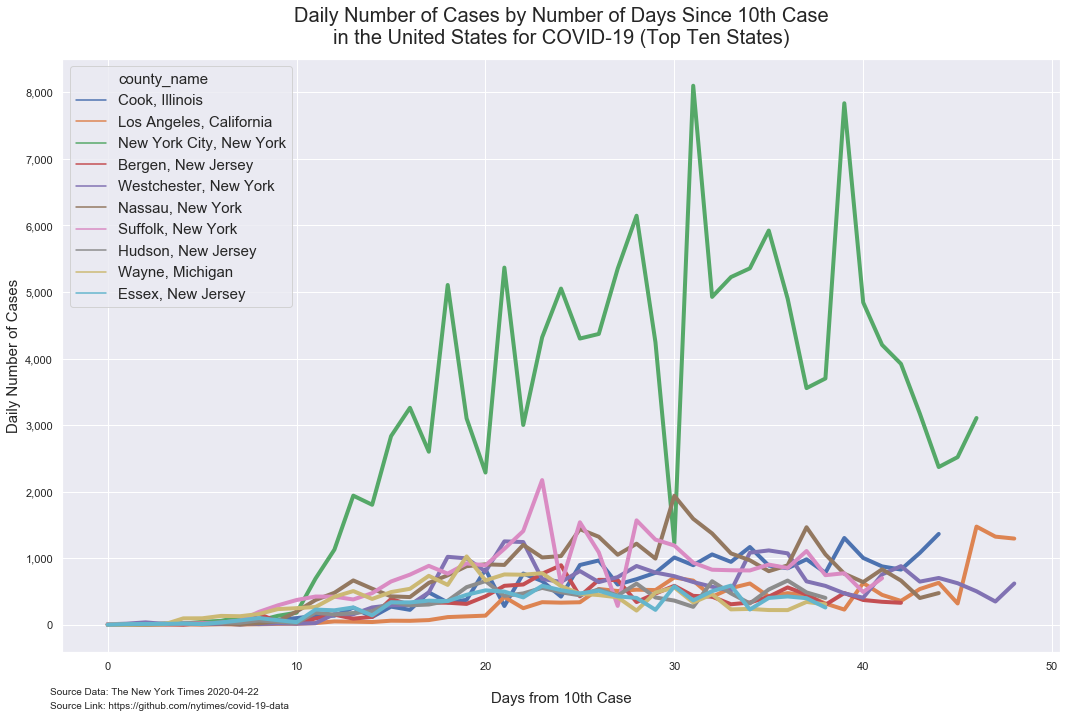

In [57]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily')

In [58]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
132    0.0
432    0.0
477    0.0
Name: daily_cases, dtype: float64

In [59]:
temp_fill_zeros = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[temp_fill_zeros.daily_cases == 0] = 1

temp_fill_zeros

date       county            county_name  cases  daily_cases  \
238 2020-03-11       Bergen     Bergen, New Jersey     11          1.0   
239 2020-03-12       Bergen     Bergen, New Jersey     13          2.0   
240 2020-03-13       Bergen     Bergen, New Jersey     17          4.0   
241 2020-03-14       Bergen     Bergen, New Jersey     31         14.0   
242 2020-03-15       Bergen     Bergen, New Jersey     32          1.0   
..         ...          ...                    ...    ...          ...   
326 2020-04-18  Westchester  Westchester, New York  23179        703.0   
327 2020-04-19  Westchester  Westchester, New York  23803        624.0   
328 2020-04-20  Westchester  Westchester, New York  24306        503.0   
329 2020-04-21  Westchester  Westchester, New York  24655        349.0   
330 2020-04-22  Westchester  Westchester, New York  25275        620.0   

     deaths date_ten_case  days_since_ten_case  
238       1    2020-03-11                    0  
239       1    2020-03-11                    1  
240       1    2020-03-11                    2  
241       1    2020-03-11                    3  
242       1    2020-03-11                    4  
..      ...           ...                  ...  
326     738    2020-03-05                   44  
327     831    2020-03-05                   45  
328     867    2020-03-05                   46  
329     904    2020-03-05                   47  
330     932    2020-03-05                   48  

[437 rows x 8 columns]

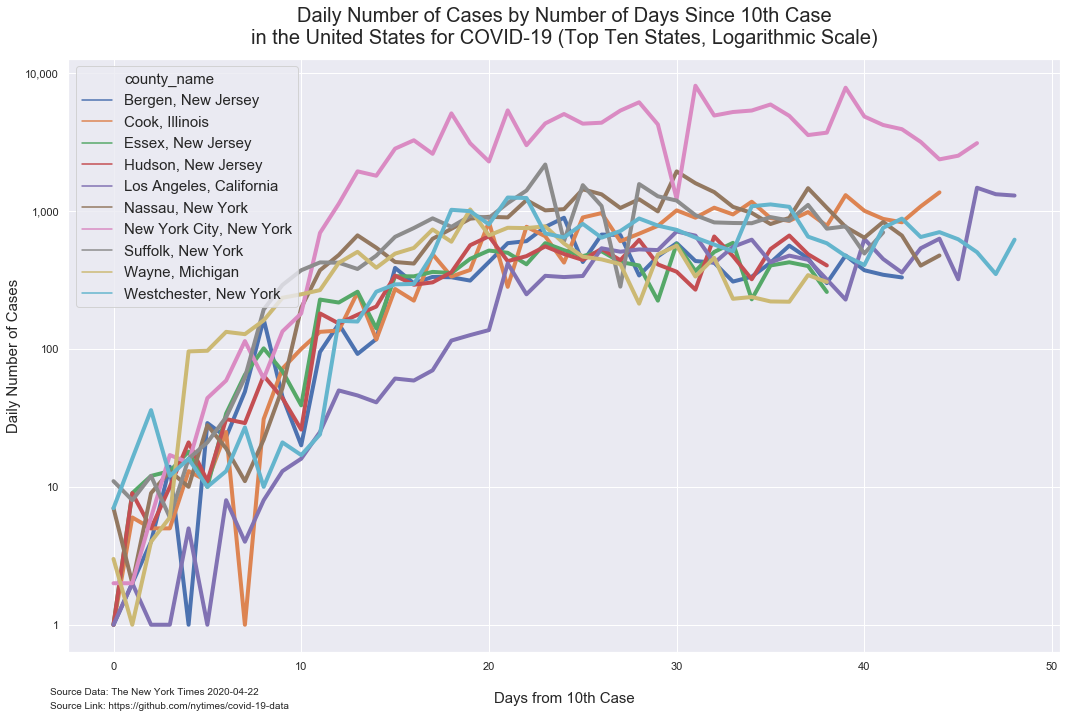

In [60]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily-log')

In [61]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
132    0.0
432    0.0
477    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [62]:
county_ten_cases_weekly = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                    ascending=[True, True, True])

In [63]:
county_ten_cases_weekly[0:30]

date  county         county_name  cases  daily_cases  deaths  \
238 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
243 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
244 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
245 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
246 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
247 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
248 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
249 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
250 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
251 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
252 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
253 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
254 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
255 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
256 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
257 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
258 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
259 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
260 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
261 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
262 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
263 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
264 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
265 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
266 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
267 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   

    date_ten_case  days_since_ten_case  
238    2020-03-11                    0  
239    2020-03-11                    1  
240    2020-03-11                    2  
241    2020-03-11                    3  
242    2020-03-11                    4  
243    2020-03-11                    5  
244    2020-03-11                    6  
245    2020-03-11                    7  
246    2020-03-11                    8  
247    2020-03-11                    9  
248    2020-03-11                   10  
249    2020-03-11                   11  
250    2020-03-11                   12  
251    2020-03-11                   13  
252    2020-03-11                   14  
253    2020-03-11                   15  
254    2020-03-11                   16  
255    2020-03-11                   17  
256    2020-03-11                   18  
257    2020-03-11                   19  
258    2020-03-11                   20  
259    2020-03-11                   21  
260    2020-03-11                   22  
261    2020-03-11                   23  
262    2020-03-11                   24  
263    2020-03-11                   25  
264    2020-03-11                   26  
265    2020-03-11                   27  
266    2020-03-11                   28  
267    2020-03-11                   29

In [64]:
county_ten_cases_weekly = county_ten_cases_weekly.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [65]:
county_ten_cases_weekly

days_since_ten_case  daily_cases
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     4.400000
                      2020-03-22                   11    60.714286
                      2020-03-29                   18   244.571429
                      2020-04-05                   25   574.000000
                      2020-04-12                   32   513.857143
...                                               ...          ...
Westchester, New York 2020-03-29                   24   949.428571
                      2020-04-05                   31   743.285714
                      2020-04-12                   38   798.714286
                      2020-04-19                   45   641.428571
                      2020-04-26                   48   490.666667

[73 rows x 2 columns]

In [66]:
county_ten_cases_weekly.reset_index(inplace=True)
county_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [67]:
county_ten_cases_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
68  Westchester, New York 2020-03-29                   24   
69  Westchester, New York 2020-04-05                   31   
70  Westchester, New York 2020-04-12                   38   
71  Westchester, New York 2020-04-19                   45   
72  Westchester, New York 2020-04-26                   48   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
68                949.428571  
69                743.285714  
70                798.714286  
71                641.428571  
72                490.666667  

[73 rows x 4 columns]

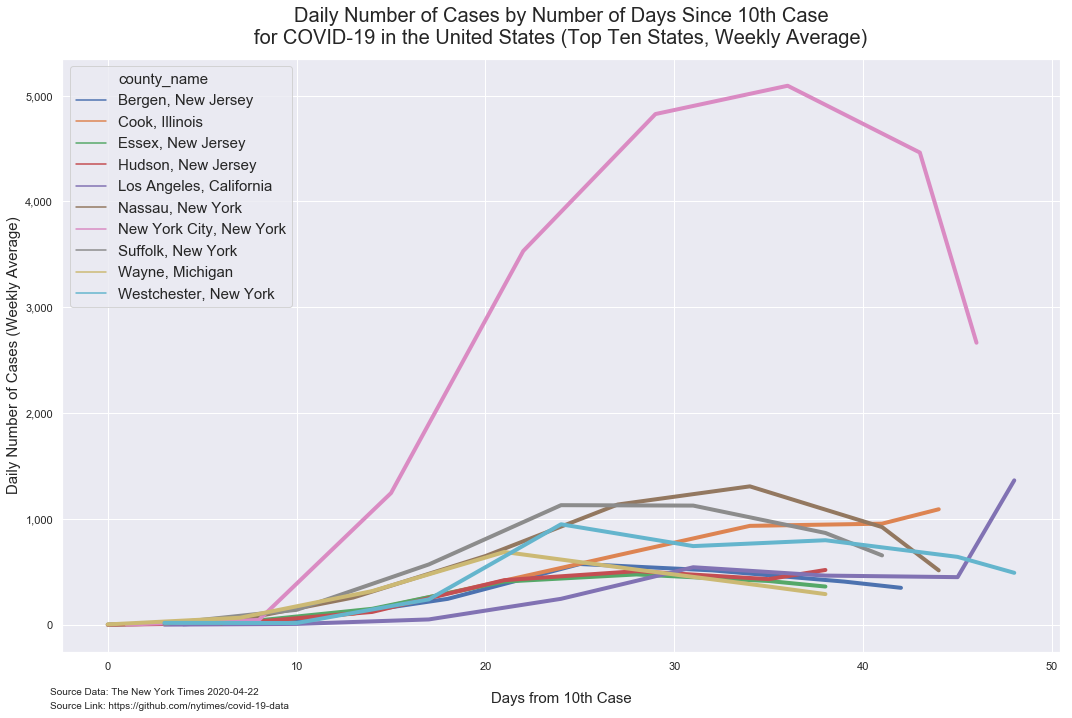

In [68]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly')

In [69]:
county_ten_cases_weekly.sort_values(by='daily_cases_week_average')

county_name       date  days_since_ten_case  \
21       Hudson, New Jersey 2020-03-15                    0   
28  Los Angeles, California 2020-03-08                    3   
14        Essex, New Jersey 2020-03-15                    0   
43  New York City, New York 2020-03-08                    1   
58          Wayne, Michigan 2020-03-15                    0   
..                      ...        ...                  ...   
50  New York City, New York 2020-04-26                   46   
46  New York City, New York 2020-03-29                   22   
49  New York City, New York 2020-04-19                   43   
47  New York City, New York 2020-04-05                   29   
48  New York City, New York 2020-04-12                   36   

    daily_cases_week_average  
21                  0.000000  
28                  1.000000  
14                  1.000000  
43                  2.000000  
58                  3.000000  
..                       ...  
50               2665.333333  
46               3531.857143  
49               4462.571429  
47               4826.285714  
48               5093.714286  

[73 rows x 4 columns]

In [70]:
temp_fill_zeros = county_ten_cases_weekly.sort_values(by=['county_name', 'date','daily_cases_week_average'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases_week_average'].loc[temp_fill_zeros.daily_cases_week_average == 0] = 1

temp_fill_zeros

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
68  Westchester, New York 2020-03-29                   24   
69  Westchester, New York 2020-04-05                   31   
70  Westchester, New York 2020-04-12                   38   
71  Westchester, New York 2020-04-19                   45   
72  Westchester, New York 2020-04-26                   48   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
68                949.428571  
69                743.285714  
70                798.714286  
71                641.428571  
72                490.666667  

[73 rows x 4 columns]

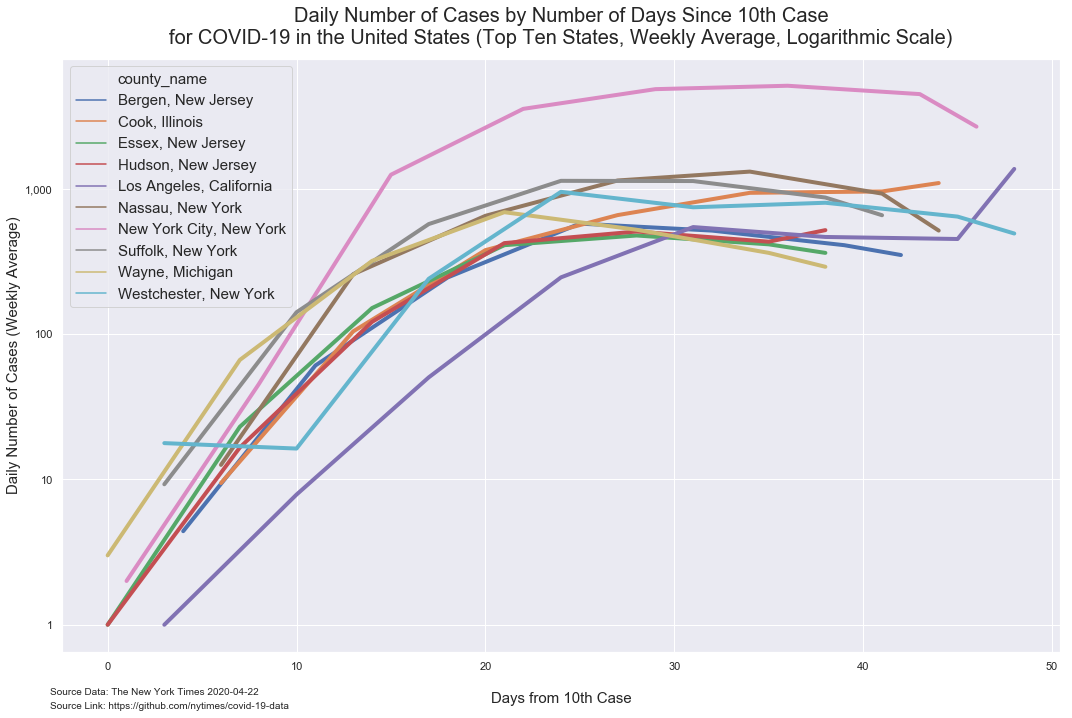

In [71]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [72]:
growth_rate = county_ten_cases.sort_values(by=['county_name', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [73]:
growth_rate.head()

date  county         county_name  cases  daily_cases  deaths  \
238 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   

    date_ten_case  days_since_ten_case  
238    2020-03-11                    0  
239    2020-03-11                    1  
240    2020-03-11                    2  
241    2020-03-11                    3  
242    2020-03-11                    4

In [74]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [75]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
238 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
243 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
244 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
245 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
246 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
247 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
248 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
249 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
250 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
251 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
252 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
253 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
254 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
255 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
256 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
257 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
258 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
259 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
260 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
261 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
262 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
263 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
264 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
265 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
266 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
267 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
268 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
269 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
270 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
271 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
272 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
273 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
274 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
275 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
276 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
277 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
278 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
279 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
280 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   

    date_ten_case  days_since_ten_case  growth_rate  
238    2020-03-11                    0          NaN  
239    2020-03-11                    1     2.000000  
240    2020-03-11                    2     2.000000  
241    2020-03-11  

In [76]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [77]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [78]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
243 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
244 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
245 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
246 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
247 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
248 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
249 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
250 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
251 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
252 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
253 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
254 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
255 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
256 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
257 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
258 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
259 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
260 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
261 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
262 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
263 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
264 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
265 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
266 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
267 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
268 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
269 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
270 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
271 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
272 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
273 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
274 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
275 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
276 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
277 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
278 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
279 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
280 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   

    date_ten_case  days_since_ten_case  growth_rate  
239    2020-03-11                    1     2.000000  
240    2020-03-11                    2     2.000000  
241    2020-03-11                    3     3.500000  
242    2020-03-11  

In [79]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [80]:
growth_rate.isna().sum()

date                   0
county                 0
county_name            0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [81]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
243 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
244 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
245 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
246 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
247 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
248 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
249 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
250 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
251 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
252 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
253 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
254 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
255 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
256 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
257 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
258 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
259 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
260 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
261 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
262 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
263 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
264 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
265 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
266 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
267 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
268 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
269 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
270 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
271 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
272 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
273 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
274 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
275 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
276 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
277 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
278 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
279 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
280 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   

    date_ten_case  days_since_ten_case  growth_rate  
239    2020-03-11                    1     2.000000  
240    2020-03-11                    2     2.000000  
241    2020-03-11                    3     3.500000  
242    2020-03-11  

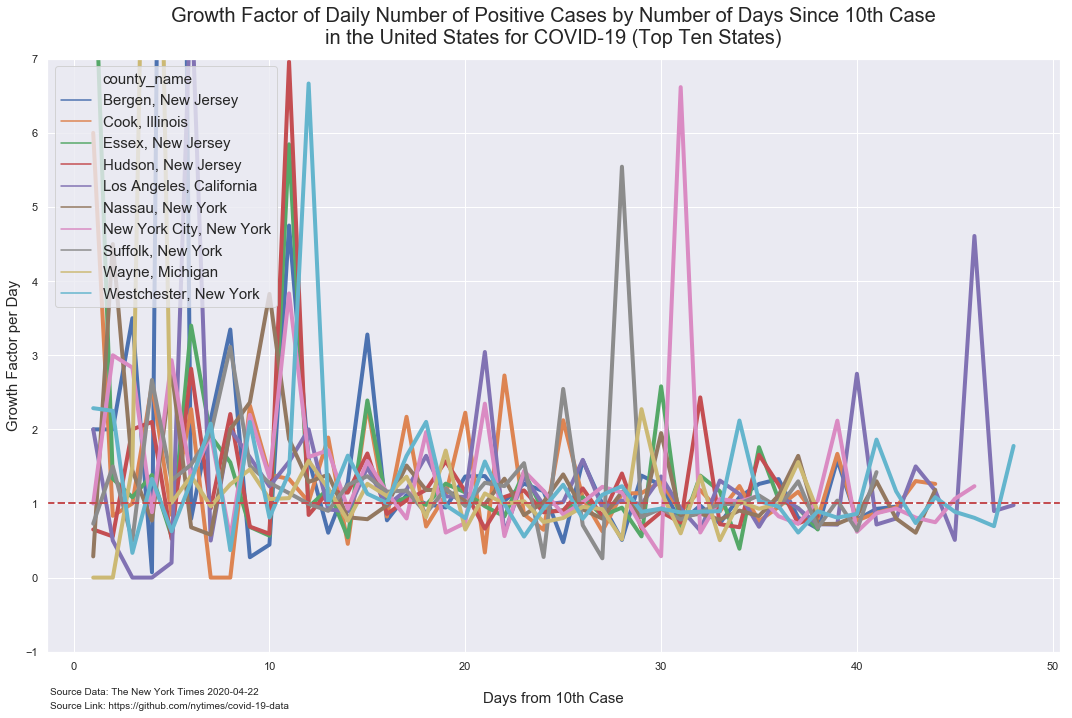

In [82]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="county_name", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 7)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [83]:
growth_rate_weekly = growth_rate.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [84]:
growth_rate_weekly

days_since_ten_case  growth_rate
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     1.892857
                      2020-03-22                   11     5.819902
                      2020-03-29                   18     1.378264
                      2020-04-05                   25     1.089289
                      2020-04-12                   32     1.060000
...                                               ...          ...
Westchester, New York 2020-03-29                   24     1.132506
                      2020-04-05                   31     1.013730
                      2020-04-12                   38     1.057008
                      2020-04-19                   45     1.057690
                      2020-04-26                   48     1.092144

[70 rows x 2 columns]

In [85]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [86]:
growth_rate_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
65  Westchester, New York 2020-03-29                   24   
66  Westchester, New York 2020-04-05                   31   
67  Westchester, New York 2020-04-12                   38   
68  Westchester, New York 2020-04-19                   45   
69  Westchester, New York 2020-04-26                   48   

    growth_rate_weekly_average  
0                     1.892857  
1                     5.819902  
2                     1.378264  
3                     1.089289  
4                     1.060000  
..                         ...  
65                    1.132506  
66                    1.013730  
67                    1.057008  
68                    1.057690  
69                    1.092144  

[70 rows x 4 columns]

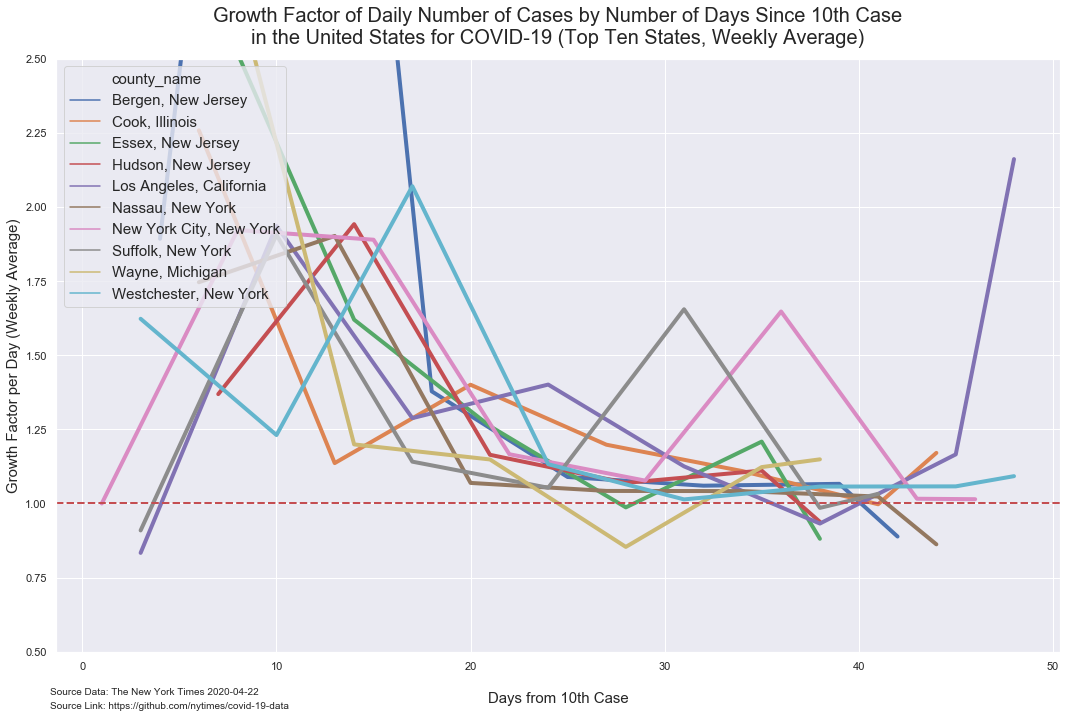

In [87]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="county_name", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2.5)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

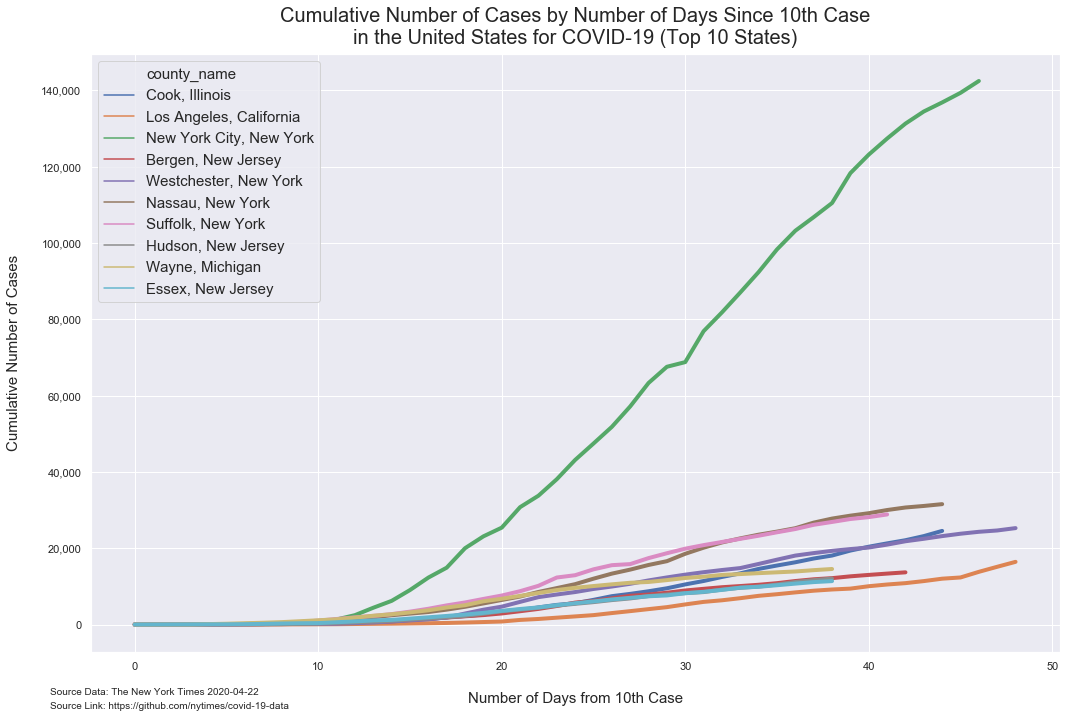

In [88]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case')

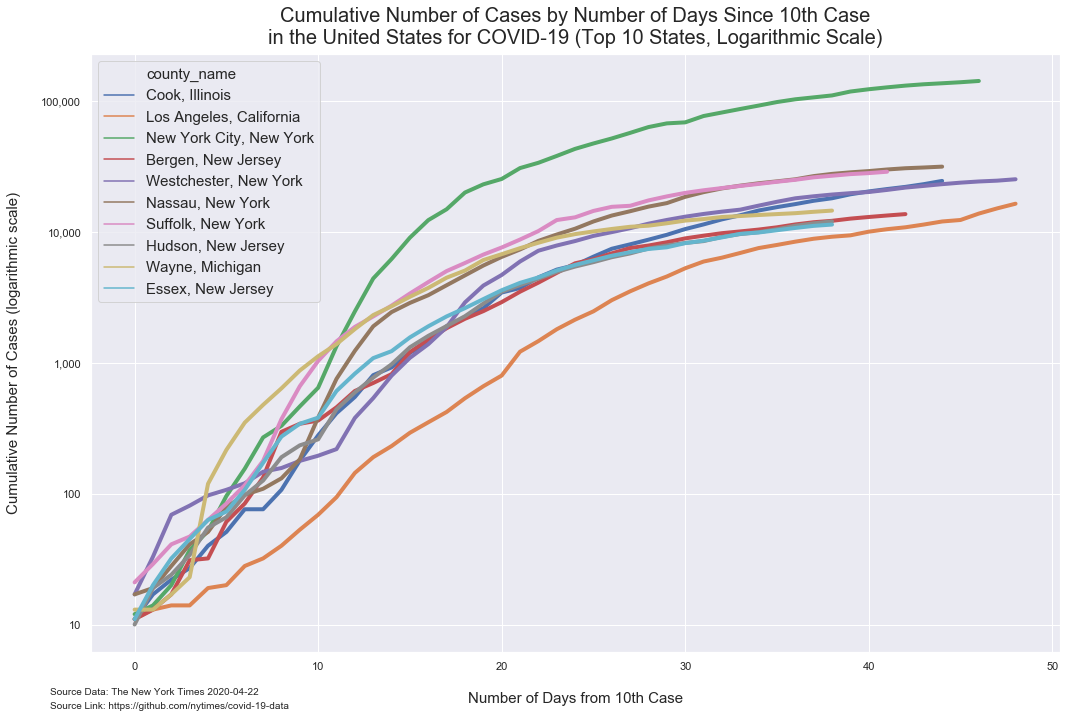

In [89]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [90]:
ten_cases_all_states = covid_19_counties_data.loc[covid_19_counties_data['cases'] >= 10]

In [91]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="county_name", keep = 'first').reset_index(drop=True)

In [92]:
ten_cases_all_states = ten_cases_all_states[['county_name', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [93]:
ten_cases_all_states

county_name ten_cases_date
0           Douglas, Nebraska     2020-02-17
1                Bexar, Texas     2020-02-24
2          Solano, California     2020-02-26
3            King, Washington     2020-03-01
4     Santa Clara, California     2020-03-03
...                       ...            ...
1717            Fannin, Texas     2020-04-22
1718            Upshur, Texas     2020-04-22
1719         Greene, Arkansas     2020-04-22
1720           Williams, Ohio     2020-04-22
1721          Polk, Minnesota     2020-04-22

[1722 rows x 2 columns]

In [94]:
ten_cases_all_states = covid_19_counties_data.merge(ten_cases_all_states, left_on='county_name', right_on='county_name')

In [95]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [96]:
ten_cases_all_states

date             county       state     fips  cases  deaths  \
44    2020-03-05          Snohomish  Washington  53061.0     17       0   
45    2020-03-06          Snohomish  Washington  53061.0     18       0   
46    2020-03-07          Snohomish  Washington  53061.0     26       0   
47    2020-03-08          Snohomish  Washington  53061.0     36       0   
48    2020-03-09          Snohomish  Washington  53061.0     45       0   
...          ...                ...         ...      ...    ...     ...   
57851 2020-04-20  Falls Church city    Virginia  51610.0     24       0   
57852 2020-04-21  Falls Church city    Virginia  51610.0     24       1   
57853 2020-04-22  Falls Church city    Virginia  51610.0     25       1   
57861 2020-04-21             Saline    Nebraska  31151.0     11       0   
57862 2020-04-22             Saline    Nebraska  31151.0     16       0   

                       county_name ten_cases_date  
44           Snohomish, Washington     2020-03-05  
45           Snohomish, Washington     2020-03-05  
46           Snohomish, Washington     2020-03-05  
47           Snohomish, Washington     2020-03-05  
48           Snohomish, Washington     2020-03-05  
...                            ...            ...  
57851  Falls Church city, Virginia     2020-04-20  
57852  Falls Church city, Virginia     2020-04-20  
57853  Falls Church city, Virginia     2020-04-20  
57861             Saline, Nebraska     2020-04-21  
57862             Saline, Nebraska     2020-04-21  

[36765 rows x 8 columns]

In [97]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [98]:
ten_cases_all_states

date             county       state     fips  cases  deaths  \
44    2020-03-05          Snohomish  Washington  53061.0     17       0   
45    2020-03-06          Snohomish  Washington  53061.0     18       0   
46    2020-03-07          Snohomish  Washington  53061.0     26       0   
47    2020-03-08          Snohomish  Washington  53061.0     36       0   
48    2020-03-09          Snohomish  Washington  53061.0     45       0   
...          ...                ...         ...      ...    ...     ...   
57851 2020-04-20  Falls Church city    Virginia  51610.0     24       0   
57852 2020-04-21  Falls Church city    Virginia  51610.0     24       1   
57853 2020-04-22  Falls Church city    Virginia  51610.0     25       1   
57861 2020-04-21             Saline    Nebraska  31151.0     11       0   
57862 2020-04-22             Saline    Nebraska  31151.0     16       0   

                       county_name ten_cases_date  days_from_10_cases  
44           Snohomish, Washington     2020-03-05                   0  
45           Snohomish, Washington     2020-03-05                   1  
46           Snohomish, Washington     2020-03-05                   2  
47           Snohomish, Washington     2020-03-05                   3  
48           Snohomish, Washington     2020-03-05                   4  
...                            ...            ...                 ...  
57851  Falls Church city, Virginia     2020-04-20                   0  
57852  Falls Church city, Virginia     2020-04-20                   1  
57853  Falls Church city, Virginia     2020-04-20                   2  
57861             Saline, Nebraska     2020-04-21                   0  
57862             Saline, Nebraska     2020-04-21                   1  

[36765 rows x 9 columns]

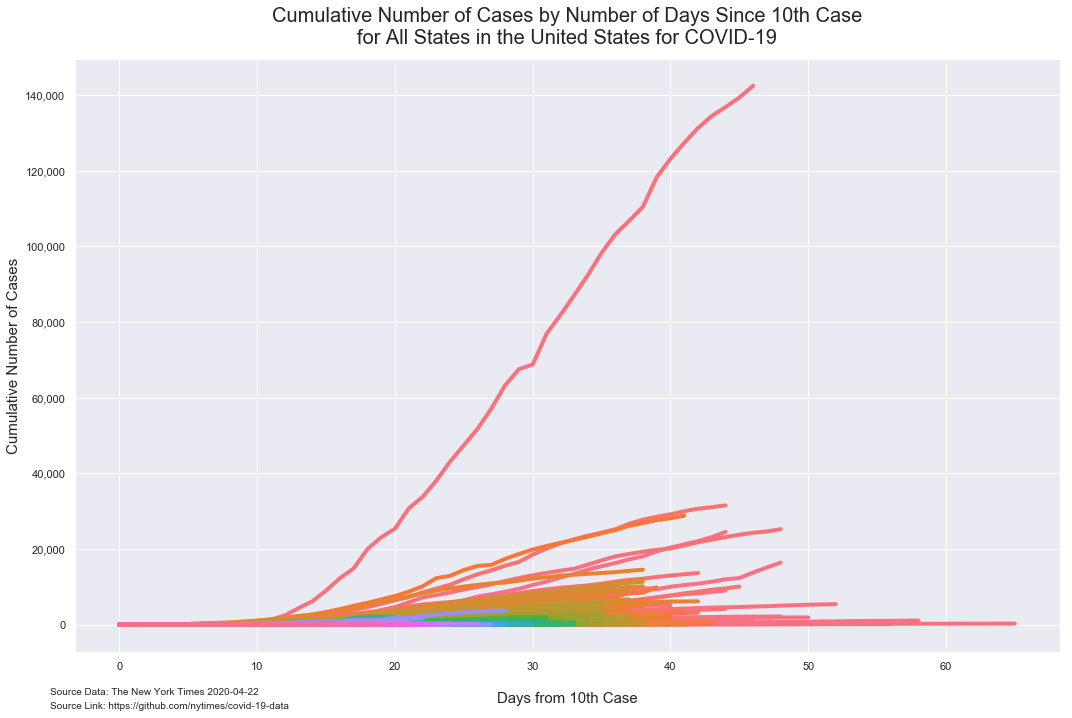

In [99]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties')

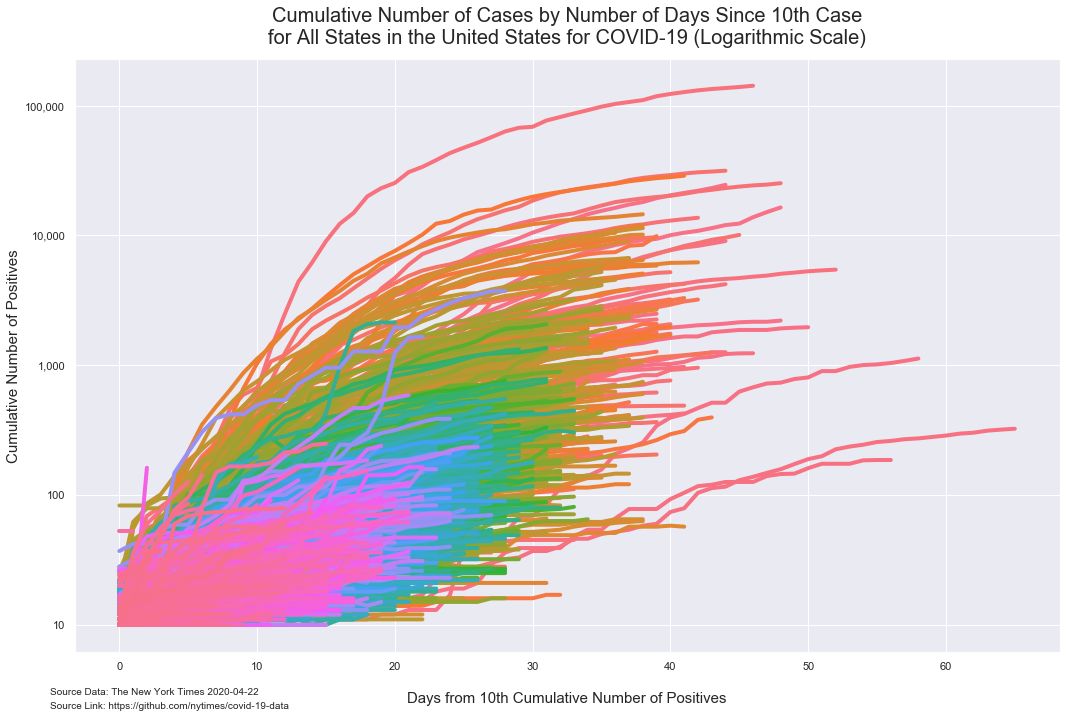

In [100]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [101]:
trajectory_plot = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [102]:
trajectory_plot[:50]

date  county         county_name  cases  daily_cases  deaths  \
238 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
239 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
240 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
241 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
242 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
243 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
244 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
245 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
246 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
247 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
248 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
249 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
250 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
251 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
252 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
253 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
254 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
255 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
256 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
257 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
258 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
259 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
260 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
261 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
262 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
263 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
264 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
265 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
266 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
267 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
268 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
269 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
270 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
271 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
272 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
273 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
274 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
275 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
276 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
277 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
278 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
279 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
280 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   

    date_ten_case  days_since_ten_case  
238    2020-03-11                    0  
239    2020-03-11                    1  
240    2020-03-11                    2  
241    2020-03-11                    3  
242    2020-03-11             

In [103]:
trajectory_plot.sort_values(by='daily_cases')

date         county              county_name   cases  daily_cases  \
52  2020-03-16           Cook           Cook, Illinois      76          0.0   
432 2020-03-15         Hudson       Hudson, New Jersey      10          0.0   
132 2020-03-08    Los Angeles  Los Angeles, California      14          0.0   
477 2020-03-16          Wayne          Wayne, Michigan      13          0.0   
45  2020-03-09           Cook           Cook, Illinois      11          1.0   
..         ...            ...                      ...     ...          ...   
205 2020-03-28  New York City  New York City, New York   30766       5367.0   
219 2020-04-11  New York City  New York City, New York   98308       5924.0   
212 2020-04-04  New York City  New York City, New York   63307       6147.0   
223 2020-04-15  New York City  New York City, New York  118302       7837.0   
215 2020-04-07  New York City  New York City, New York   76876       8100.0   

     deaths date_ten_case  days_since_ten_case  
52        0    2020-03-09                    7  
432       0    2020-03-15                    0  
132       0    2020-03-05                    3  
477       0    2020-03-15                    1  
45        0    2020-03-09                    0  
..      ...           ...                  ...  
205     672    2020-03-07                   21  
219    6202    2020-03-07                   35  
212    2254    2020-03-07                   28  
223    8215    2020-03-07                   39  
215    4009    2020-03-07                   31  

[437 rows x 8 columns]

In [104]:
trajectory_plot['daily_cases'].loc[trajectory_plot.daily_cases == 0] = 1

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


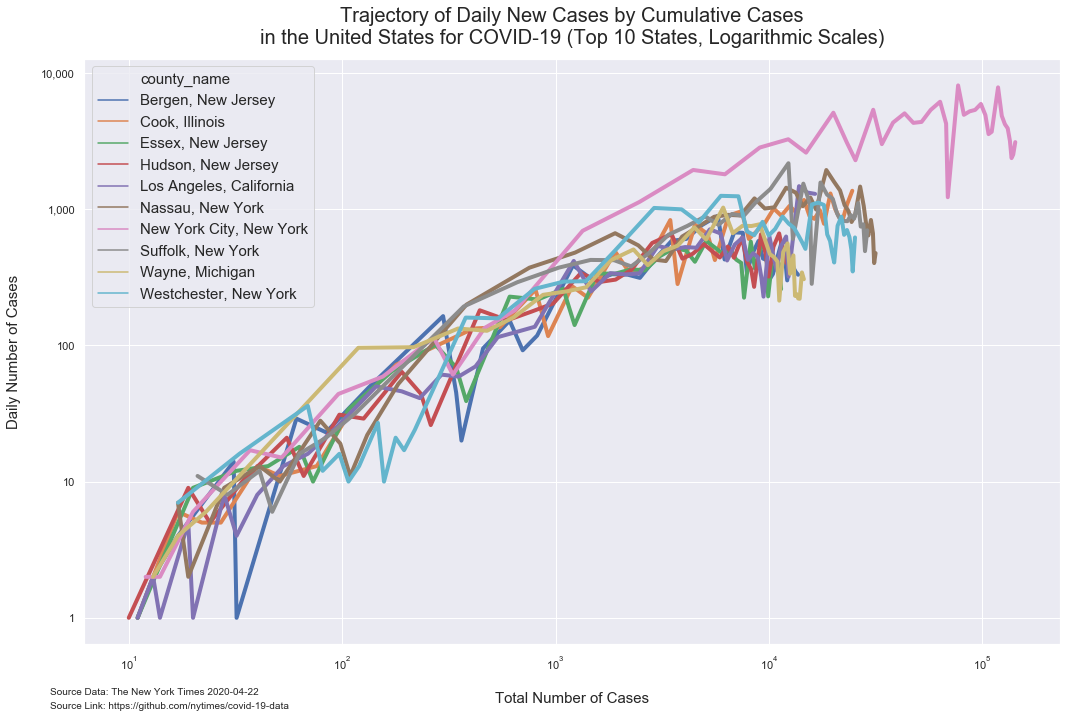

In [105]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="county_name",
             data=trajectory_plot, linewidth=4, ci=False)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
#plt.savefig('figures/county-trajectory-daily-plot')

## Weekly

In [106]:
trajectory_plot_weekly = trajectory_plot[['county_name', 'date', 'cases', 'daily_cases']]

In [107]:
trajectory_plot_weekly.head()

county_name       date  cases  daily_cases
238  Bergen, New Jersey 2020-03-11     11          1.0
239  Bergen, New Jersey 2020-03-12     13          2.0
240  Bergen, New Jersey 2020-03-13     17          4.0
241  Bergen, New Jersey 2020-03-14     31         14.0
242  Bergen, New Jersey 2020-03-15     32          1.0

In [108]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [109]:
trajectory_plot_weekly

cases  daily_cases
county_name           date                          
Bergen, New Jersey    2020-03-15     32     4.400000
                      2020-03-22    457    60.714286
                      2020-03-29   2169   244.571429
                      2020-04-05   6187   574.000000
                      2020-04-12   9784   513.857143
...                                 ...          ...
Westchester, New York 2020-03-29   8519   949.428571
                      2020-04-05  13722   743.285714
                      2020-04-12  19313   798.714286
                      2020-04-19  23803   641.428571
                      2020-04-26  25275   490.666667

[73 rows x 2 columns]

In [110]:
trajectory_plot_weekly.reset_index(inplace=True)

In [111]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [112]:
trajectory_plot_weekly

county_name       date  cases  daily_cases_weekly_average
0      Bergen, New Jersey 2020-03-15     32                    4.400000
1      Bergen, New Jersey 2020-03-22    457                   60.714286
2      Bergen, New Jersey 2020-03-29   2169                  244.571429
3      Bergen, New Jersey 2020-04-05   6187                  574.000000
4      Bergen, New Jersey 2020-04-12   9784                  513.857143
..                    ...        ...    ...                         ...
68  Westchester, New York 2020-03-29   8519                  949.428571
69  Westchester, New York 2020-04-05  13722                  743.285714
70  Westchester, New York 2020-04-12  19313                  798.714286
71  Westchester, New York 2020-04-19  23803                  641.428571
72  Westchester, New York 2020-04-26  25275                  490.666667

[73 rows x 4 columns]

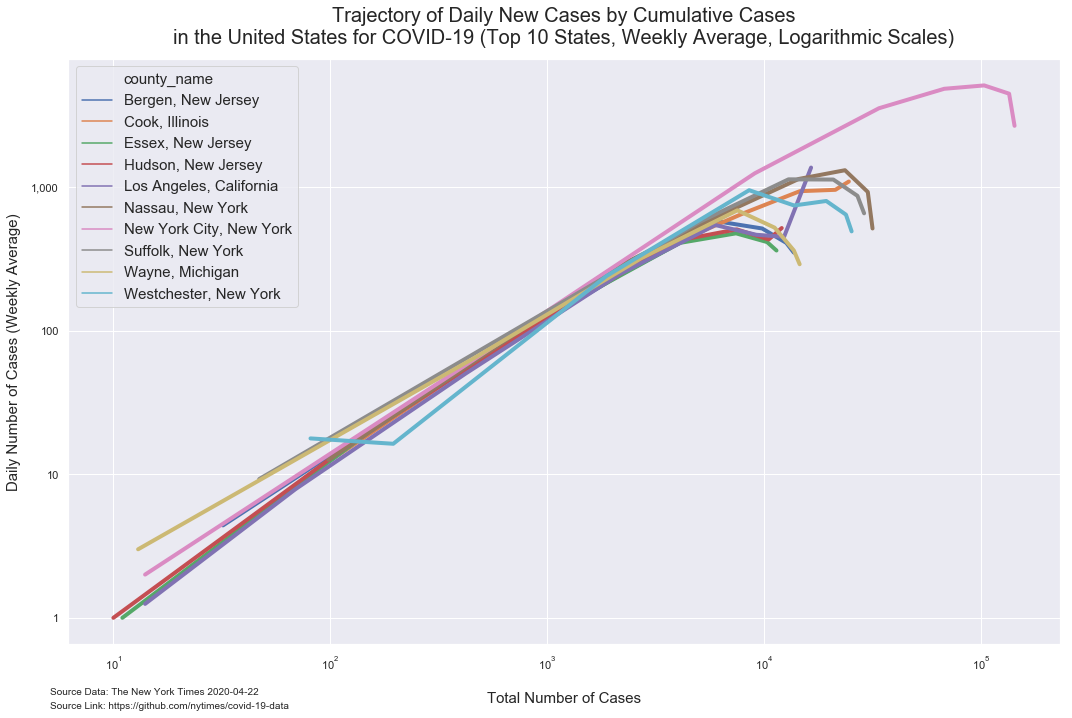

In [113]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-weekly-plot')

In [114]:
trajectory_plot_weekly_scatter = trajectory_plot_weekly.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="county_name", 
                                                                                        keep = 'first').reset_index(drop=True)

In [115]:
trajectory_plot_weekly_scatter

county_name       date   cases  daily_cases_weekly_average
0  New York City, New York 2020-04-26  142442                 2665.333333
1         Nassau, New York 2020-04-26   31555                  514.000000
2        Suffolk, New York 2020-04-26   28854                  655.333333
3    Westchester, New York 2020-04-26   25275                  490.666667
4           Cook, Illinois 2020-04-26   24546                 1091.333333
5  Los Angeles, California 2020-04-26   16435                 1364.666667
6          Wayne, Michigan 2020-04-26   14561                  289.666667
7       Bergen, New Jersey 2020-04-26   13686                  349.000000
8       Hudson, New Jersey 2020-04-26   12039                  517.666667
9        Essex, New Jersey 2020-04-26   11387                  361.000000

In [116]:
len(trajectory_plot_weekly_scatter)

10

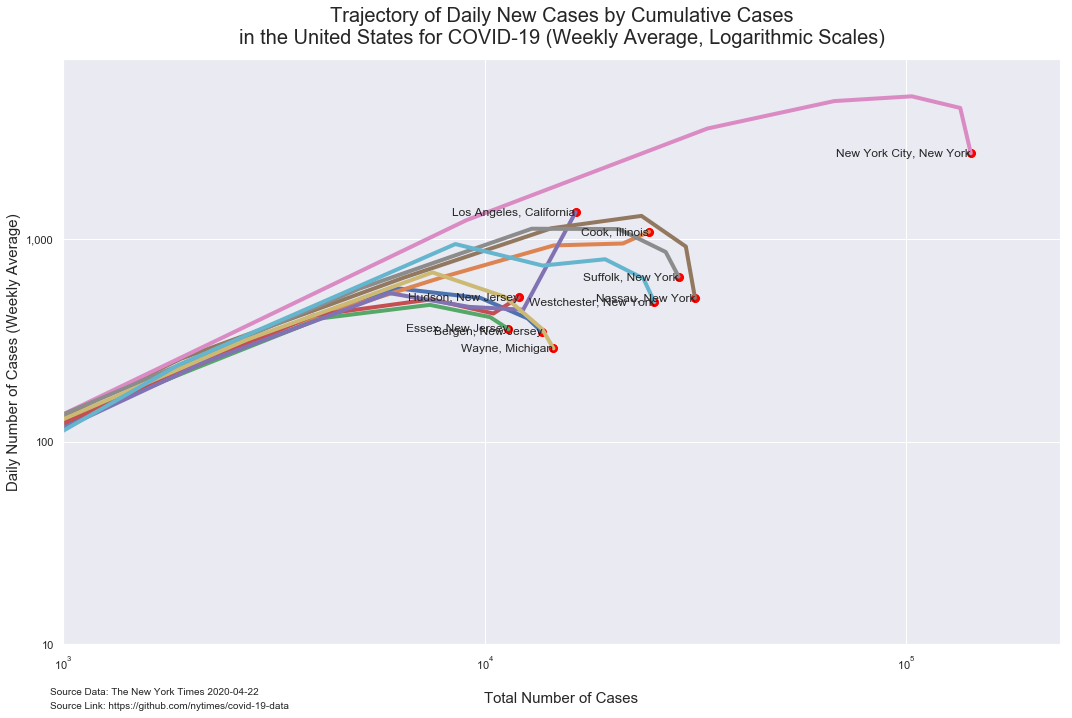

In [117]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

sns.scatterplot(x="cases", y="daily_cases_weekly_average", 
             data=trajectory_plot_weekly_scatter, s=100, ax=ax1, color='red')


x = trajectory_plot_weekly_scatter.daily_cases_weekly_average
z = trajectory_plot_weekly_scatter.cases
n = trajectory_plot_weekly_scatter.county_name
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
plt.xlim(1000)
plt.ylim(10)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot-labels')

# Trajectory for All Counties

In [118]:
trajectory_all_counties = covid_19_counties_data.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [119]:
trajectory_all_counties

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
...          ...        ...             ...      ...    ...     ...   
69875 2020-04-18     Zavala           Texas  48507.0      1       0   
72645 2020-04-19     Zavala           Texas  48507.0      1       0   
75423 2020-04-20     Zavala           Texas  48507.0      1       0   
78205 2020-04-21     Zavala           Texas  48507.0      1       0   
80998 2020-04-22     Zavala           Texas  48507.0      1       0   

                     county_name  
5000   Abbeville, South Carolina  
5873   Abbeville, South Carolina  
6877   Abbeville, South Carolina  
7997   Abbeville, South Carolina  
9209   Abbeville, South Carolina  
...                          ...  
69875              Zavala, Texas  
72645              Zavala, Texas  
75423              Zavala, Texas  
78205              Zavala, Texas  
80998              Zavala, Texas  

[80410 rows x 7 columns]

In [120]:
trajectory_all_counties['daily_cases'] = trajectory_all_counties['cases'].diff()

In [121]:
trajectory_all_counties[150:200]

date county     state     fips  cases  deaths      county_name  \
11291 2020-03-25  Adair      Iowa  19001.0      1       0      Adair, Iowa   
12859 2020-03-26  Adair      Iowa  19001.0      1       0      Adair, Iowa   
14556 2020-03-27  Adair      Iowa  19001.0      1       0      Adair, Iowa   
16368 2020-03-28  Adair      Iowa  19001.0      1       0      Adair, Iowa   
18286 2020-03-29  Adair      Iowa  19001.0      1       0      Adair, Iowa   
20305 2020-03-30  Adair      Iowa  19001.0      1       0      Adair, Iowa   
22416 2020-03-31  Adair      Iowa  19001.0      1       0      Adair, Iowa   
24601 2020-04-01  Adair      Iowa  19001.0      1       0      Adair, Iowa   
26846 2020-04-02  Adair      Iowa  19001.0      1       0      Adair, Iowa   
29152 2020-04-03  Adair      Iowa  19001.0      1       0      Adair, Iowa   
31522 2020-04-04  Adair      Iowa  19001.0      1       0      Adair, Iowa   
33934 2020-04-05  Adair      Iowa  19001.0      1       0      Adair, Iowa   
36391 2020-04-06  Adair      Iowa  19001.0      1       0      Adair, Iowa   
38888 2020-04-07  Adair      Iowa  19001.0      1       0      Adair, Iowa   
41432 2020-04-08  Adair      Iowa  19001.0      1       0      Adair, Iowa   
44001 2020-04-09  Adair      Iowa  19001.0      1       0      Adair, Iowa   
46603 2020-04-10  Adair      Iowa  19001.0      1       0      Adair, Iowa   
49235 2020-04-11  Adair      Iowa  19001.0      1       0      Adair, Iowa   
51899 2020-04-12  Adair      Iowa  19001.0      1       0      Adair, Iowa   
54580 2020-04-13  Adair      Iowa  19001.0      1       0      Adair, Iowa   
57274 2020-04-14  Adair      Iowa  19001.0      1       0      Adair, Iowa   
59982 2020-04-15  Adair      Iowa  19001.0      1       0      Adair, Iowa   
62707 2020-04-16  Adair      Iowa  19001.0      1       0      Adair, Iowa   
65443 2020-04-17  Adair      Iowa  19001.0      1       0      Adair, Iowa   
68194 2020-04-18  Adair      Iowa  19001.0      1       0      Adair, Iowa   
70956 2020-04-19  Adair      Iowa  19001.0      1       0      Adair, Iowa   
73728 2020-04-20  Adair      Iowa  19001.0      1       0      Adair, Iowa   
76506 2020-04-21  Adair      Iowa  19001.0      1       0      Adair, Iowa   
79289 2020-04-22  Adair      Iowa  19001.0      1       0      Adair, Iowa   
34057 2020-04-05  Adair  Kentucky  21001.0      3       0  Adair, Kentucky   
36519 2020-04-06  Adair  Kentucky  21001.0      3       0  Adair, Kentucky   
39023 2020-04-07  Adair  Kentucky  21001.0      4       1  Adair, Kentucky   
41568 2020-04-08  Adair  Kentucky  21001.0      4       1  Adair, Kentucky   
44137 2020-04-09  Adair  Kentucky  21001.0      9       1  Adair, Kentucky   
46742 2020-04-10  Adair  Kentucky  21001.0     10       1  Adair, Kentucky   
49378 2020-04-11  Adair  Kentucky  21001.0     11       1  Adair, Kentucky   
52044 2020-04-12  Adair  Kentucky  21001.0     43       1  Adair, Kentucky   
54725 2020-04-13  Adair  Kentucky  21001.0     43       1  Adair, Kentucky   
57421 2020-04-14  Adair  Kentucky  21001.0     44       2  Adair, Kentucky   
60130 2020-04-15  Adair  Kentucky  21001.0     45       2  Adair, Kentucky   
62854 2020-04-16  Adair  Kentucky  21001.0     46       3  Adair, Kentucky   
65595 2020-04-17  Adair  Kentucky  21001.0     46       3  Adair, Kentucky   
68346 2020-04-18  Adair  Kentucky  21001.0     47       3  Adair, Kentucky   
71107 2020-04-19  Adair  Kentucky  21001.0     53       3  Adair, Kentucky   
73880 2020-04-20  Adair  Kentucky  21001.0     54       4  Adair, Kentucky   
76661 2020-04-21  Adair  Kentucky  21001.0     53       4  Adair, Kentucky   
79445 2020-04-22  Adair  Kentucky  21001.0     60       4  Adair, Kentucky   
8892  2020-03-23  Adair  Missouri  29001.0      2       0  Adair, Missouri   
10194 2020-03-24  Adair  Missouri  29001.0      2       0  Adair, Missouri   
11620 2020-03-25  Adair  Missouri  29001.0      2       0  Adair, Missouri   

       daily_cases  
11291       

In [122]:
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases < 0] = trajectory_all_counties.cases
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases.isnull()] = trajectory_all_counties.cases

In [123]:
trajectory_all_counties[:50]

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
10539 2020-03-24  Abbeville  South Carolina  45001.0      1       0   
12015 2020-03-25  Abbeville  South Carolina  45001.0      3       0   
13647 2020-03-26  Abbeville  South Carolina  45001.0      4       0   
15404 2020-03-27  Abbeville  South Carolina  45001.0      4       0   
17268 2020-03-28  Abbeville  South Carolina  45001.0      4       0   
19222 2020-03-29  Abbeville  South Carolina  45001.0      4       0   
21283 2020-03-30  Abbeville  South Carolina  45001.0      3       0   
23435 2020-03-31  Abbeville  South Carolina  45001.0      4       0   
25642 2020-04-01  Abbeville  South Carolina  45001.0      4       0   
27915 2020-04-02  Abbeville  South Carolina  45001.0      6       0   
30250 2020-04-03  Abbeville  South Carolina  45001.0      6       0   
32643 2020-04-04  Abbeville  South Carolina  45001.0      6       0   
35082 2020-04-05  Abbeville  South Carolina  45001.0      6       0   
37560 2020-04-06  Abbeville  South Carolina  45001.0      6       0   
40080 2020-04-07  Abbeville  South Carolina  45001.0      5       0   
42636 2020-04-08  Abbeville  South Carolina  45001.0      6       0   
45216 2020-04-09  Abbeville  South Carolina  45001.0      7       0   
47832 2020-04-10  Abbeville  South Carolina  45001.0      7       0   
50487 2020-04-11  Abbeville  South Carolina  45001.0      9       0   
53160 2020-04-12  Abbeville  South Carolina  45001.0      9       0   
55847 2020-04-13  Abbeville  South Carolina  45001.0      9       0   
58550 2020-04-14  Abbeville  South Carolina  45001.0      9       0   
61268 2020-04-15  Abbeville  South Carolina  45001.0     10       0   
63996 2020-04-16  Abbeville  South Carolina  45001.0     10       0   
66744 2020-04-17  Abbeville  South Carolina  45001.0     10       0   
69502 2020-04-18  Abbeville  South Carolina  45001.0     15       0   
72270 2020-04-19  Abbeville  South Carolina  45001.0     17       0   
75047 2020-04-20  Abbeville  South Carolina  45001.0     17       0   
77829 2020-04-21  Abbeville  South Carolina  45001.0     18       0   
80620 2020-04-22  Abbeville  South Carolina  45001.0     22       0   
7518  2020-03-22     Acadia       Louisiana  22001.0      1       0   
8681  2020-03-23     Acadia       Louisiana  22001.0      1       0   
9973  2020-03-24     Acadia       Louisiana  22001.0      2       0   
11381 2020-03-25     Acadia       Louisiana  22001.0      2       0   
12963 2020-03-26     Acadia       Louisiana  22001.0      3       0   
14680 2020-03-27     Acadia       Louisiana  22001.0      8       1   
16507 2020-03-28     Acadia       Louisiana  22001.0      9       1   
18432 2020-03-29     Acadia       Louisiana  22001.0      9       1   
20461 2020-03-30     Acadia       Louisiana  22001.0     11       1   
22585 2020-03-31     Acadia       Louisiana  22001.0     39       1   
24773 2020-04-01     Acadia       Louisiana  22001.0     47       1   
27028 2020-04-02     Acadia       Louisiana  22001.0     61       1   
29340 2020-04-03     Acadia       Louisiana  22001.0     72       1   
31720 2020-04-04     Acadia       Louisiana  22001.0     65       2   
34146 2020-04-05     Acadia       Louisiana  22001.0     75       2   

                     county_name  daily_cases  
5000   Abbeville, South Carolina          1.0  
5873   Abbeville, South Carolina          0.0  
6877   Abbeville, South Carolina          0.0  
7997   Abbeville, South Carolina          0.0  
9209   Abbeville, South Carolina          0.0  
10539  Abbeville, South Carolina          0.0  
12015  Abbeville, South Carolina          2.0  
13647 

In [124]:
trajectory_all_counties = trajectory_all_counties.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_counties.reset_index(inplace=True)
trajectory_all_counties.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [125]:
trajectory_all_counties.head()

county_name       date  cases  daily_cases_week_avg
0  Abbeville, South Carolina 2020-03-22    1.0              0.250000
1  Abbeville, South Carolina 2020-03-29    4.0              0.428571
2  Abbeville, South Carolina 2020-04-05    6.0              0.857143
3  Abbeville, South Carolina 2020-04-12    9.0              1.285714
4  Abbeville, South Carolina 2020-04-19   17.0              1.142857

In [126]:
temp_fill_zeros = trajectory_all_counties.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['cases'].loc[temp_fill_zeros.cases < 1] = 1
temp_fill_zeros['daily_cases_week_avg'].loc[temp_fill_zeros.daily_cases_week_avg < 1] = 1

temp_fill_zeros

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
14297              Zapata, Texas 2020-04-12    3.0              1.000000
14298              Zapata, Texas 2020-04-19    6.0              1.000000
14299              Zapata, Texas 2020-04-26    7.0              1.000000
14300              Zavala, Texas 2020-04-19    1.0              1.000000
14301              Zavala, Texas 2020-04-26    1.0              1.000000

[14302 rows x 4 columns]

In [127]:
temp_fill_zeros.loc[temp_fill_zeros.cases.isnull() == True]

county_name       date  cases  daily_cases_week_avg
857           Benzie, Michigan 2020-04-12    NaN                   NaN
3476        Decatur, Tennessee 2020-04-05    NaN                   NaN
6177   Jackson, North Carolina 2020-04-12    NaN                   NaN
8115          Marion, Missouri 2020-04-12    NaN                   NaN
10871          Rhea, Tennessee 2020-04-12    NaN                   NaN
14231            Yoakum, Texas 2020-04-12    NaN                   NaN

In [128]:
temp_fill_zeros.dropna()

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
14297              Zapata, Texas 2020-04-12    3.0              1.000000
14298              Zapata, Texas 2020-04-19    6.0              1.000000
14299              Zapata, Texas 2020-04-26    7.0              1.000000
14300              Zavala, Texas 2020-04-19    1.0              1.000000
14301              Zavala, Texas 2020-04-26    1.0              1.000000

[14296 rows x 4 columns]

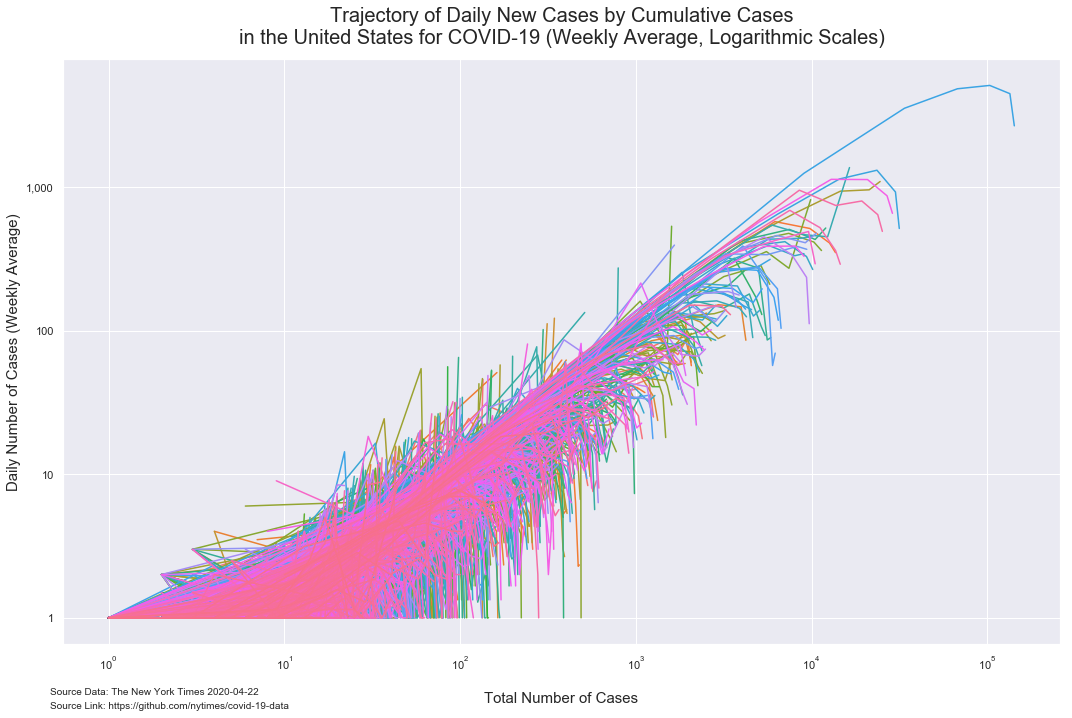

In [129]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="county_name",
             data=temp_fill_zeros, ci=False)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot')

# Timeseries for USA

In [130]:
g = covid_19_counties_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [131]:
g.index.dtype

dtype('<M8[ns]')

In [132]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [133]:
g.tail()

date   cases
date                         
2020-04-18 2020-04-18  721808
2020-04-19 2020-04-19  747262
2020-04-20 2020-04-20  773989
2020-04-21 2020-04-21  799200
2020-04-22 2020-04-22  826293

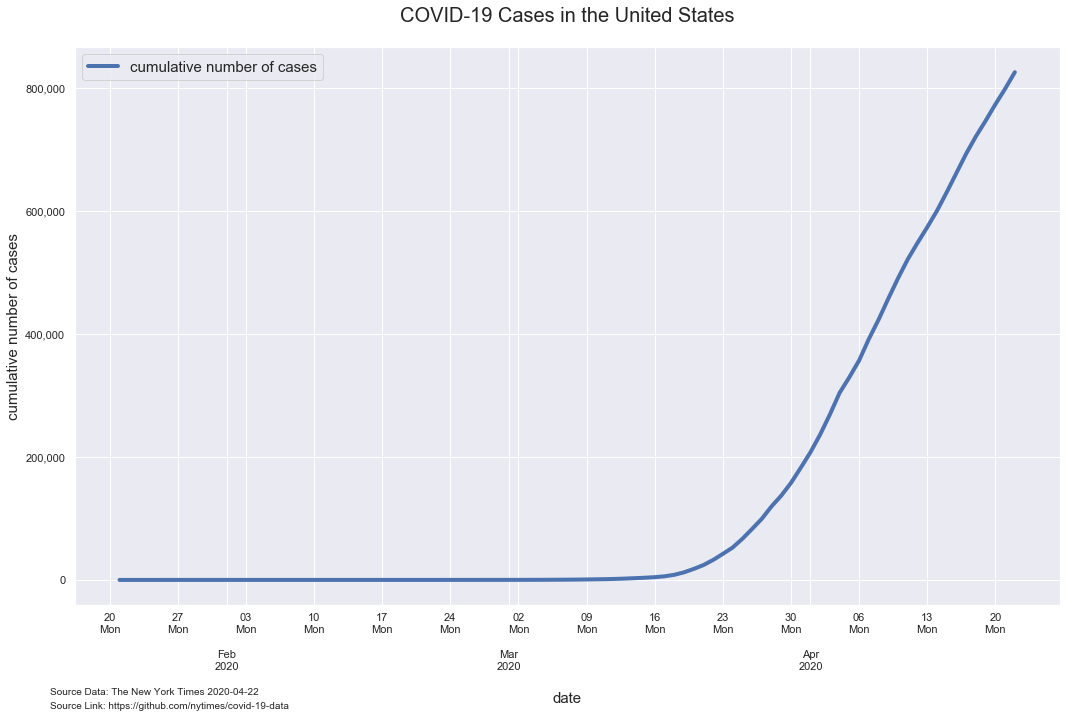

In [134]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-linear')

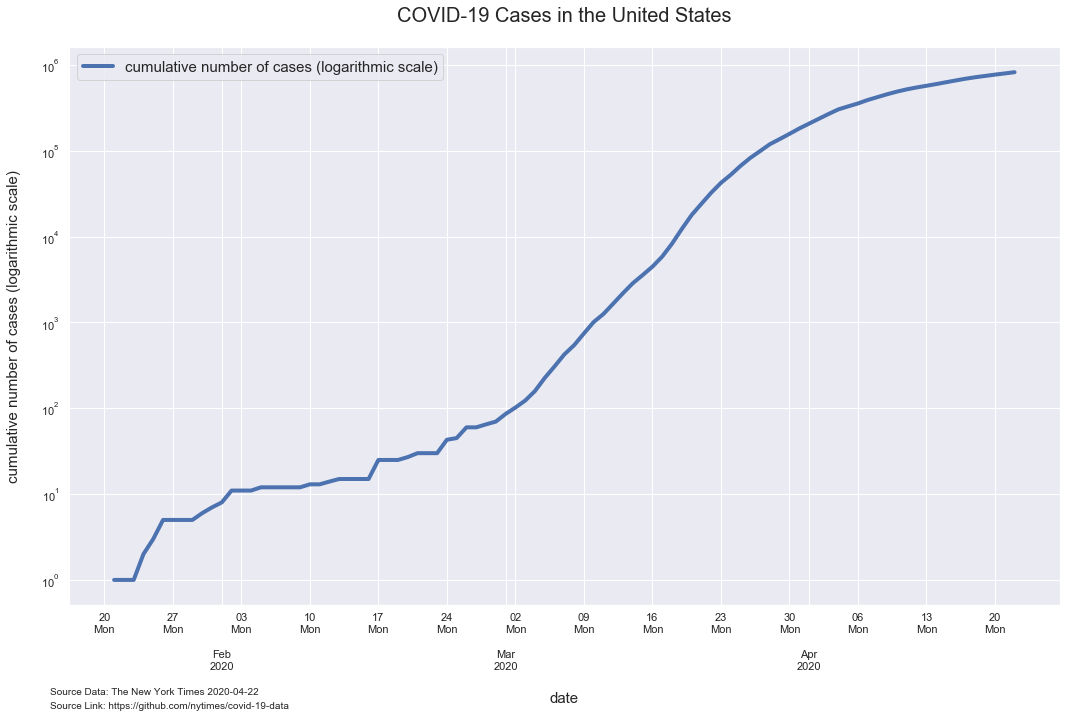

In [135]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/counties-log')

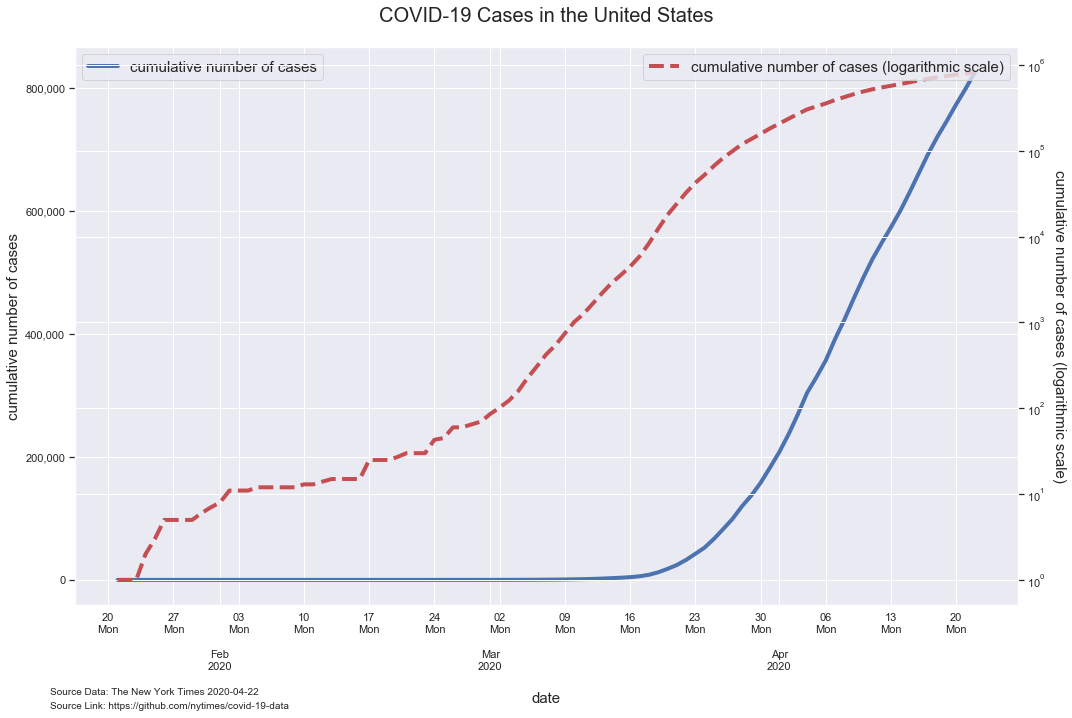

In [136]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-timeseries-overlay')

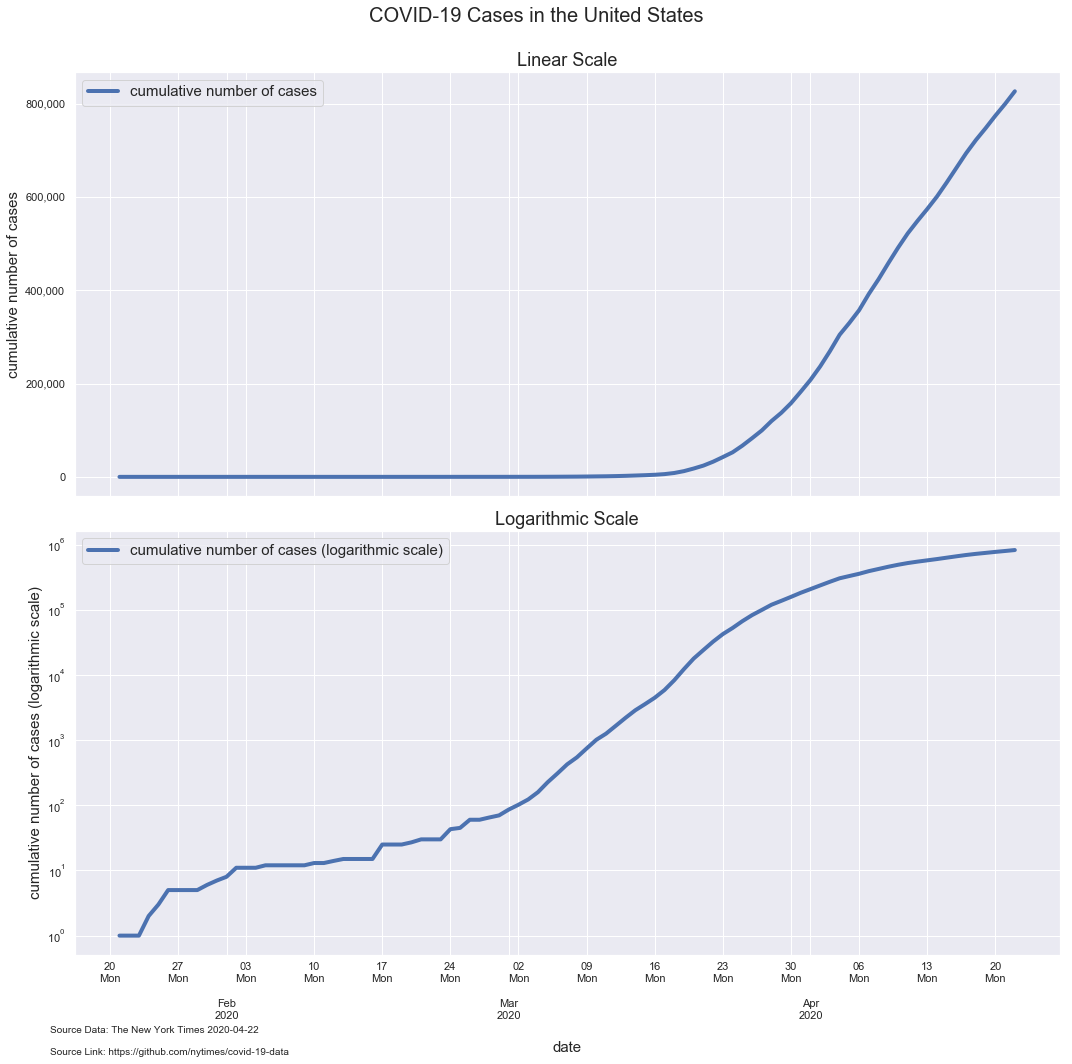

In [137]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/counties-timeseries-2-subplots')

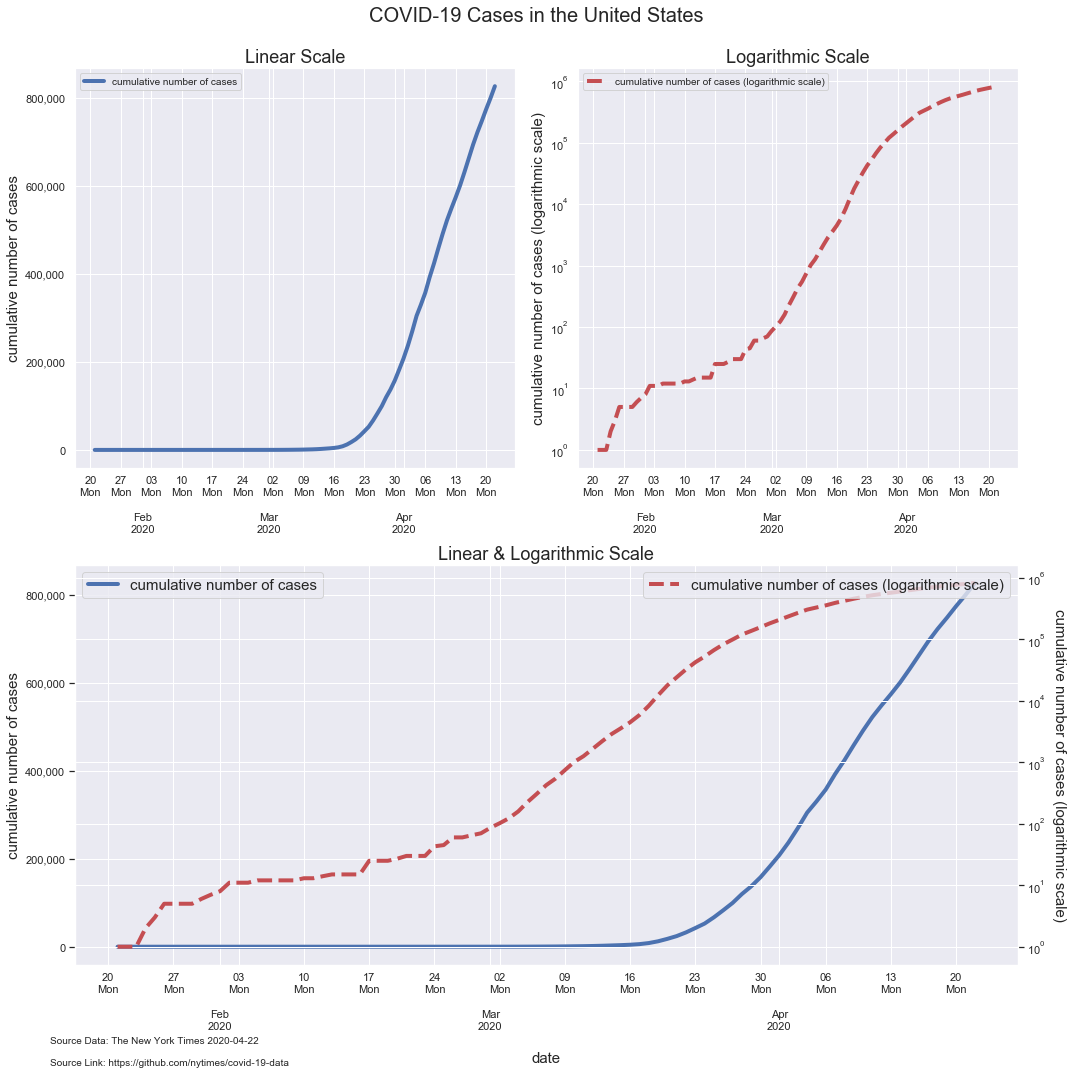

In [138]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-3-subplots')

# Country Trajectory Plot

In [139]:
g['daily_cases'] = g['cases'].diff()

In [140]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [141]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [142]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     86         16.0
2020-03-02 2020-03-02    102         16.0
2020-03-03 2020-03-03    123         21.0
2020-03-04 2020-03-04    159         36.0
2020-03-05 2020-03-05    226         67.0
2020-03-06 2020-03-06    308         82.0
2020-03-07 2020-03-07    425        117.0
2020-03-08 2020-03-08    544        119.0
2020-03-09 2020-03-09    745        201.0
2020-03-10 2020-03-10   1013        268.0

In [143]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [144]:
g_weekly

cases   daily_cases
date                            
2020-01-26       5      0.833333
2020-02-02      11      0.857143
2020-02-09      12      0.142857
2020-02-16      15      0.428571
2020-02-23      30      2.142857
2020-03-01      86      8.000000
2020-03-08     544     65.428571
2020-03-15    3570    432.285714
2020-03-22   32503   4133.285714
2020-03-29  137191  14955.428571
2020-04-05  329963  27538.857143
2020-04-12  548541  31225.428571
2020-04-19  747262  28388.714286
2020-04-26  826293  26343.666667

In [145]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [146]:
g_weekly

date   cases   daily_cases
0  2020-01-26       5      0.833333
1  2020-02-02      11      0.857143
2  2020-02-09      12      0.142857
3  2020-02-16      15      0.428571
4  2020-02-23      30      2.142857
5  2020-03-01      86      8.000000
6  2020-03-08     544     65.428571
7  2020-03-15    3570    432.285714
8  2020-03-22   32503   4133.285714
9  2020-03-29  137191  14955.428571
10 2020-04-05  329963  27538.857143
11 2020-04-12  548541  31225.428571
12 2020-04-19  747262  28388.714286
13 2020-04-26  826293  26343.666667

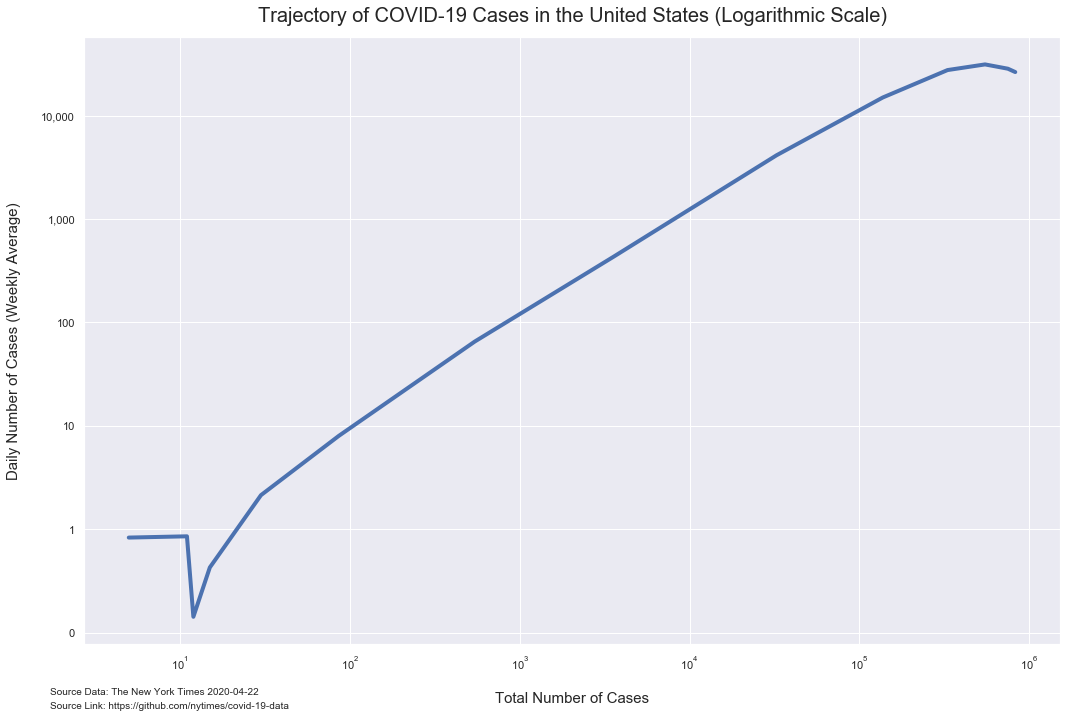

In [147]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/usa-counties-trajectory-weekly-plot')

# Bar Chart

In [148]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
81334 2020-04-22    Sublette     Wyoming  56035.0      1       0   
81335 2020-04-22  Sweetwater     Wyoming  56037.0     10       0   
81336 2020-04-22       Teton     Wyoming  56039.0     63       0   
81337 2020-04-22       Uinta     Wyoming  56041.0      6       0   
81338 2020-04-22    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
81334      Sublette, Wyoming  
81335    Sweetwater, Wyoming  
81336         Teton, Wyoming  
81337         Uinta, Wyoming  
81338      Washakie, Wyoming  

[80410 rows x 7 columns]

In [149]:
# dropping ALL duplicate values 
county_current_cases = covid_19_counties_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="county_name", keep = 'first')

In [150]:
county_current_cases.head()

date    county     state     fips  cases  deaths  \
81338 2020-04-22  Washakie   Wyoming  56043.0      4       0   
79473 2020-04-22  Edmonson  Kentucky  21061.0      8       0   
79481 2020-04-22     Grant  Kentucky  21081.0     19       3   
79480 2020-04-22   Garrard  Kentucky  21079.0      1       0   
79479 2020-04-22  Gallatin  Kentucky  21077.0      1       0   

              county_name  
81338   Washakie, Wyoming  
79473  Edmonson, Kentucky  
79481     Grant, Kentucky  
79480   Garrard, Kentucky  
79479  Gallatin, Kentucky

In [151]:
county_current_cases.county_name.value_counts()

Banks, Georgia            1
Williamson, Tennessee     1
Gunnison, Colorado        1
Mecosta, Michigan         1
Shawnee, Kansas           1
                         ..
Delaware, Pennsylvania    1
Lyon, Nevada              1
Baxter, Arkansas          1
Cedar, Iowa               1
Pendleton, Kentucky       1
Name: county_name, Length: 2780, dtype: int64

In [152]:
county_current_cases.loc[county_current_cases.county == 'New York City']

date         county     state  fips   cases  deaths  \
80202 2020-04-22  New York City  New York   NaN  142442   10614   

                   county_name  
80202  New York City, New York

In [153]:
bar = county_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar = bar[:20]

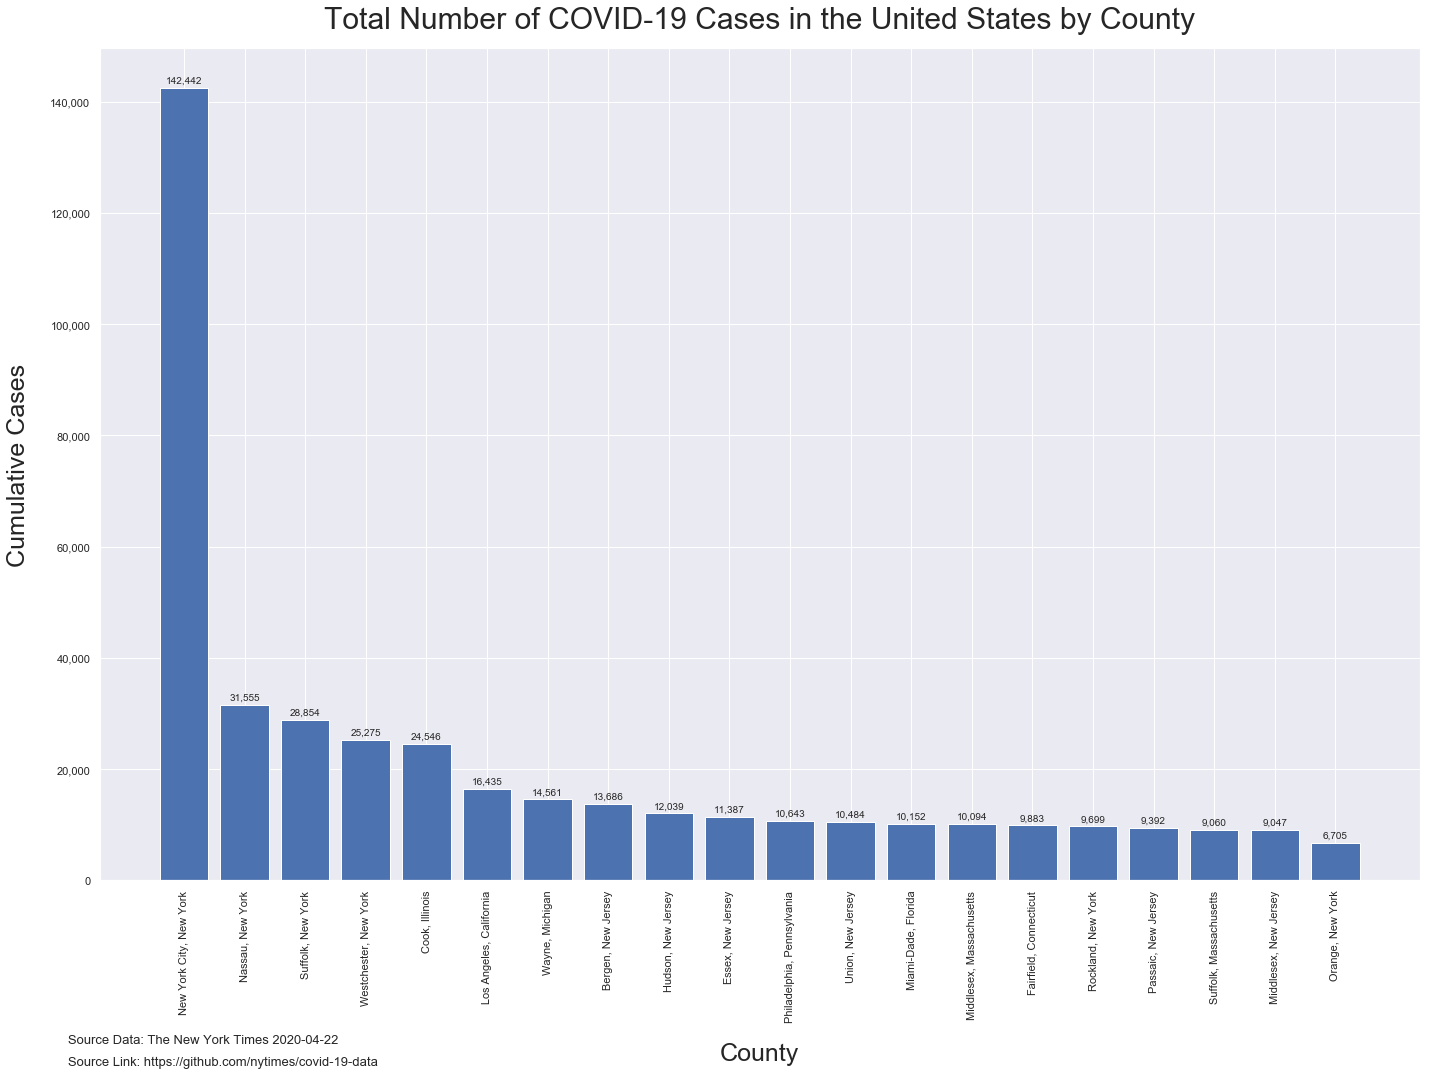

In [154]:
bar = bar.sort_values(by = 'cases', 
                    ascending=False)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("County", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-bar')

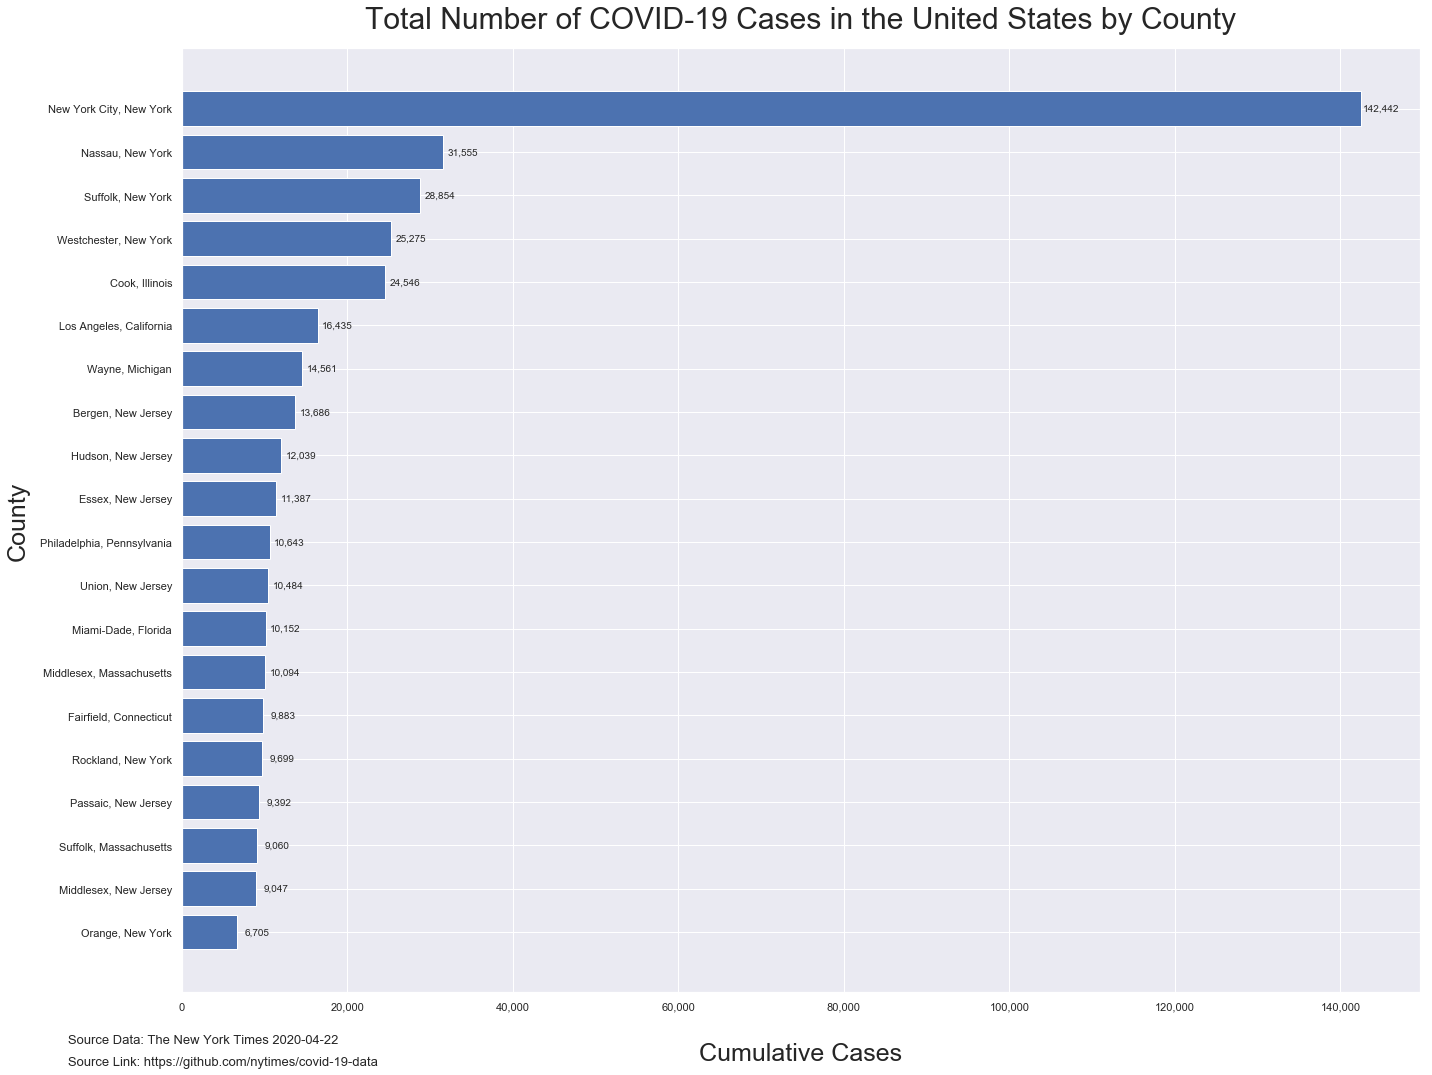

In [155]:
bar = bar.sort_values(by = 'cases', 
                    ascending=True)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("County", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-barh')

In [156]:
covid_19_counties_data.to_csv('data/us-counties-raw-data.csv', index=False)
g.to_csv('data/us-counties-grouped-day.csv')
bar.to_csv('data/us-counties-grouped-bar.csv')